# Emotion Recognition 

This project implements a complete facial emotion recognition pipeline using the FER2013 dataset.

It follows a structured process of preprocessing, feature extraction, model training, evaluation, and real-time inference.

The goal is to recognize seven facial emotions from grayscale 48×48 images using machine learning models.

The pipeline integrates both texture (HOG) and geometry (landmark) features, and compares three classifiers:
- Support Vector Machine (SVM)
- Multi-Layer Perceptron (MLP)
- Random Forest (RF)

The process includes:
1. Data loading and preprocessing  
2. Handling class imbalance  
3. Extracting Histogram of Oriented Gradients (HOG) features  
4. Training a Support Vector Machine (SVM) classifier  
5. Evaluating the model on validation (PublicTest) and test (PrivateTest) sets  
6. Visualizing results (class imbalance, HOG features, confusion matrices)  
7. Running a real-time emotion detection demo using OpenCV

# Environment Setup

Before running this notebook, please create the required Conda environment using the provided YAML file.  
This ensures all dependencies for the fuzzy emotion recognition pipeline are correctly installed.

## Step 1: Create the Conda environment
Open a terminal in the project root directory and run:
```bash
conda env create -f environment_mac.yml

conda activate fuzzy_emotion_recognition

## Step 2: Download FER2013 dataset

This project uses the **FER2013** dataset.  
Please place the dataset file inside the `/data/` directory before running the notebook.

Example: /ml_emotion_recognition/data/fer2013.csv

Then load the dataset with:
```python
import pandas as pd
df = pd.read_csv("data/fer2013.csv")

In [2]:
import pandas as pd
import numpy as np
import os
import joblib
import cv2
import seaborn as sns
import random
import time
import matplotlib.pyplot as plt
import mediapipe as mp

from imgaug import augmenters as iaa
from joblib import Parallel, delayed
from itertools import product
from imblearn.over_sampling import SMOTE
from pathlib import Path
from tqdm import tqdm
from typing import Tuple, Dict
from skimage import exposure
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from skimage.feature import hog
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix
)


# 1. Data Loading and Splitting
The FER2013 dataset contains 48×48 grayscale facial images,
each labeled with one of seven emotion categories:
- 0 = angry
- 1 = disgust
- 2 = fear
- 3 = happy
- 4 = sad
- 5 = surprise
- 6 = neutral

The dataset provides three splits:
- Training (fit the model)
- PublicTest (validation for hyperparameter tuning)
- PrivateTest (final test for generalization)

Train size: 28709
/ Validation size: 3589
/ Test size: 3589

In [6]:
# Read FER2013 dataset
df = pd.read_csv("data/fer2013.csv")

# Split data by Usage column
train_df = df[df["Usage"] == "Training"].copy()
val_df   = df[df["Usage"] == "PublicTest"].copy()
test_df  = df[df["Usage"] == "PrivateTest"].copy()

# Emotion label mapping
emotion_labels = {
    0: "angry", 1: "disgust", 2: "fear",
    3: "happy", 4: "sad", 5: "surprise", 6: "neutral"
}

# Display dataset sizes
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 28709
Validation size: 3589
Test size: 3589


# 2. Preprocessing
Each sample in the dataset is stored as a string of pixel values.  
These steps convert the strings to 48×48 grayscale arrays and normalize them to the range [0, 1].

In [7]:
# Convert pixel strings to 48×48 arrays and normalize
def pixels_to_array(series):
    """Convert pixel strings to normalized 48×48 float arrays."""
    return np.vstack([np.fromstring(x, sep=' ') for x in series]).reshape(-1, 48, 48) / 255.0

X_train = pixels_to_array(train_df["pixels"])
X_val   = pixels_to_array(val_df["pixels"])
X_test  = pixels_to_array(test_df["pixels"])

y_train = train_df["emotion"].values
y_val   = val_df["emotion"].values
y_test  = test_df["emotion"].values

## 2-1. Augmentation Integration

Augmentation targeted the minority emotion classes (*disgust*, *fear*, and *surprise*) to enrich sample diversity without distorting the overall class distribution. The applied transformations included:
- Horizontal flipping (always applied) — to simulate mirrored facial orientations.
- Small random rotations (±7°) — to introduce minor pose variation.
- Brightness adjustments (±10%) — to emulate illumination differences.

Each image in the selected minority classes generated a limited number of augmented samples (100% for disgust, 40% for fear and surprise), producing a moderate increase in data volume specifically for Random Forest training. No Gaussian noise was added, since FER2013 images are already low-resolution and visually noisy.

The augmented and original samples were combined and processed through the same HOG and landmark feature extraction pipelines to maintain feature consistency across models.

To mitigate class imbalance while maintaining model comparability, data augmentation was selectively applied only for the Random Forest classifier, while SVM and MLP models were trained on the original data. Random Forest benefited from additional data diversity due to its ensemble averaging, whereas SVM and MLP already reached stable validation performance without augmentation, showing no significant F1 improvement in preliminary experiments.

Visual inspection confirmed that emotional semantics were preserved while adding realistic variability. Subsequent A/B testing indicated a small but consistent F1 improvement for Random Forest, while SVM and MLP showed negligible change, validating the decision to apply augmentation only where it was most beneficial.


Total data count:  
bf. augmentation: 28709/ af. augmentation: 32051

A/B test Macro F1 Summary:

SVM  
NoAug=35.41%, WithAug=35.33%, Δ= -0.08

MLP             
NoAug=32.07%, WithAug=30.96%, Δ= -1.11

RandomForest  
NoAug=23.82%, WithAug=25.75%, Δ= +1.93


Final augmented training set size: 32051


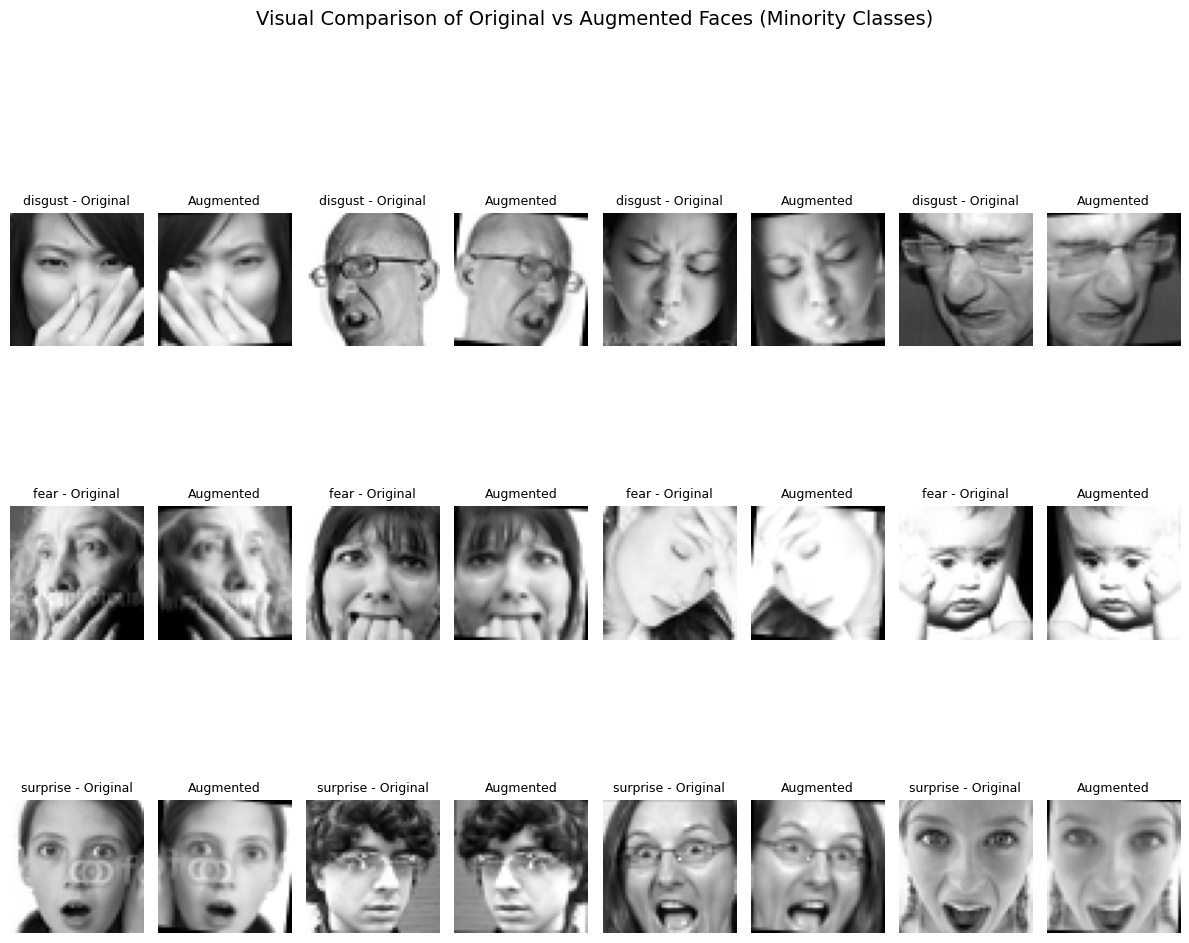


Class distribution comparison:
           Before    After  Increase  Growth(%)
angry      3995.0   3995.0       0.0        0.0
disgust     436.0    872.0     436.0      100.0
fear       4097.0   5735.0    1638.0       40.0
happy      7215.0   7215.0       0.0        0.0
sad        4830.0   4830.0       0.0        0.0
surprise   3171.0   4439.0    1268.0       40.0
neutral    4965.0   4965.0       0.0        0.0
Total     28709.0  32051.0    3342.0       11.6


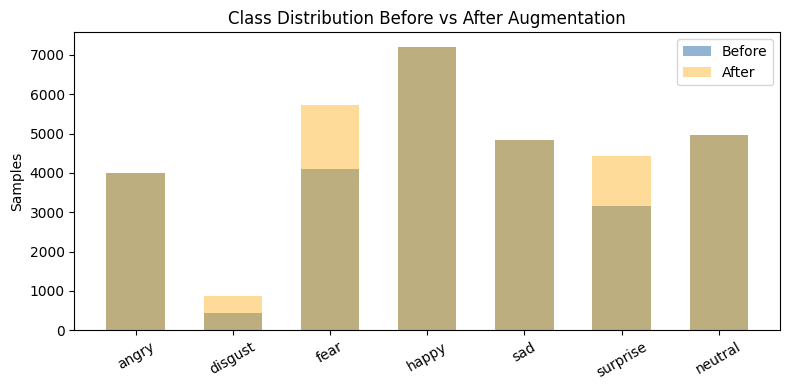

In [8]:
# ================================================================
# Data Augmentation (Training Set Only)
# ================================================================

# --- Keep original untouched ---
X_train_orig = X_train.copy()
y_train_orig = y_train.copy()

# --- Apply augmentation only to a copy (for RF or imbalance experiments) ---
X_train_aug = X_train_orig.copy()
y_train_aug = y_train_orig.copy()

# --- Define augmentation strength per class ---
augment_policy = {
    "disgust": 1.0,   # augment 100%
    "fear": 0.4,      # augment 40%
    "surprise": 0.4,  # augment 40%
    "angry": 0.0,
    "sad": 0.0,
    "neutral": 0.0,
    "happy": 0.0
}

# --- Augmentation pipeline ---
seq = iaa.Sequential([
    iaa.Fliplr(1.0),                    # always flip horizontally
    iaa.Affine(rotate=(-7, 7)),         # random rotation ±7°
    iaa.Multiply((0.9, 1.1))            # brightness ±10%
])

# --- Class-wise augmentation ---
for cls_id, cls_name in emotion_labels.items():
    idx = np.where(y_train_orig == cls_id)[0]
    X_subset = X_train_orig[idx]
    ratio = augment_policy.get(cls_name, 0)

    if ratio > 0:
        n_aug = int(len(idx) * ratio)
        sel = np.random.choice(len(X_subset), n_aug, replace=True)

        # Apply augmentation to selected samples
        X_aug = seq(images=(X_subset[sel] * 255).astype(np.uint8))
        X_aug = np.array(X_aug, dtype=np.float32) / 255.0
        y_aug = np.full(len(X_aug), cls_id)

        # Merge directly into augmented training data
        X_train_aug = np.concatenate([X_train_aug, X_aug], axis=0)
        y_train_aug = np.concatenate([y_train_aug, y_aug], axis=0)

print(f"\nFinal augmented training set size: {len(X_train_aug)}")
# ================================================================
# Visual Comparison (Original vs Augmented)
# ================================================================

target_classes = ["disgust", "fear", "surprise"]
n_per_class = 4
fig, axes = plt.subplots(len(target_classes), n_per_class * 2, figsize=(3*n_per_class, 3.5*len(target_classes)))

for r, cls_name in enumerate(target_classes):
    cls_id = [k for k, v in emotion_labels.items() if v == cls_name][0]
    idx = np.where(y_train_orig == cls_id)[0]
    chosen = np.random.choice(idx, n_per_class, replace=False)

    for c, i in enumerate(chosen):
        orig_img = X_train_orig[i]
        aug_img = seq(images=[(orig_img * 255).astype(np.uint8)])[0]

        axes[r, 2*c].imshow(orig_img, cmap="gray")
        axes[r, 2*c].set_title(f"{cls_name} - Original", fontsize=9)
        axes[r, 2*c].axis("off")

        axes[r, 2*c+1].imshow(aug_img, cmap="gray")
        axes[r, 2*c+1].set_title("Augmented", fontsize=9)
        axes[r, 2*c+1].axis("off")

plt.suptitle("Visual Comparison of Original vs Augmented Faces (Minority Classes)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ================================================================
# Class Distribution Visualization
# --- Count per class ---
counts_before = pd.Series(y_train_orig).map(emotion_labels).value_counts().sort_index()
counts_after  = pd.Series(y_train_aug).map(emotion_labels).value_counts().sort_index()

# --- Combine into one table ---
comparison = pd.DataFrame({
    "Before": counts_before,
    "After":  counts_after
}).reindex(emotion_labels.values()).fillna(0).astype(int)

# --- Display counts and growth ratio ---
comparison["Increase"] = comparison["After"] - comparison["Before"]
comparison["Growth(%)"] = (comparison["After"] / comparison["Before"] * 100 - 100).round(1).fillna(0)

# --- Add total row ---
total_before = comparison["Before"].sum()
total_after  = comparison["After"].sum()
total_increase = total_after - total_before
total_growth = (total_after / total_before * 100 - 100).round(1)

comparison.loc["Total"] = [total_before, total_after, total_increase, total_growth]

print("\nClass distribution comparison:")
print(comparison)
# ================================================================
# --- Class distribution visualization ---
plt.figure(figsize=(8,4))

before = pd.Series(y_train_orig).map(emotion_labels).value_counts().reindex(emotion_labels.values(), fill_value=0)
after  = pd.Series(y_train_aug).map(emotion_labels).value_counts().reindex(emotion_labels.values(), fill_value=0)

labels = list(emotion_labels.values())
x = np.arange(len(labels))

plt.bar(x, before.values, width=0.6, color="steelblue", alpha=0.6, label="Before")
plt.bar(x, after.values,  width=0.6, color="orange", alpha=0.4, label="After")
plt.xticks(x, labels, rotation=30)
plt.title("Class Distribution Before vs After Augmentation")
plt.ylabel("Samples")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# ================================================================
# A/B Test: Augmentation Impact across Models (SVM, MLP, RF)
# ================================================================
print("\n[INFO] Starting multi-model A/B test for augmentation impact...")

# ---------- Data sets ----------
# A: No augmentation
X_train_A, y_train_A = X_train_orig, y_train_orig
# B: With augmentation
X_train_B, y_train_B = X_train_aug, y_train_aug

# ---------- Flatten (for simple PCA input) ----------
def flatten_subset(X, y, n=None):
    """Flatten images to 1D vectors for baseline model tests."""
    if n is not None and len(X) > n:
        rng = np.random.default_rng(42) 
        idx = rng.choice(len(X), n, replace=False)
        X, y = X[idx], y[idx]
    return X.reshape(len(X), -1), y

XA, yA = flatten_subset(X_train_A, y_train_A, n=5000)
XB, yB = flatten_subset(X_train_B, y_train_B, n=5000)
Xv = X_val.reshape(len(X_val), -1)
yv = y_val

# ---------- Common pipeline builder ----------
def quick_eval(model, Xtr, ytr, Xv, yv, model_name):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=100, whiten=True, random_state=42)),
        ("clf", model)
    ])
    pipe.fit(Xtr, ytr)
    ypred = pipe.predict(Xv)
    f1 = f1_score(yv, ypred, average="macro")
    print(f"[{model_name}] Macro F1 = {f1:.4f}")
    return f1

# ---------- Models ----------
models = {
    "SVM": SVC(
        kernel="rbf", C=2.0, gamma=1e-2,
        class_weight="balanced", random_state=42
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(256,128),
        alpha=1e-4, learning_rate_init=1e-3,
        batch_size=64, max_iter=200,
        early_stopping=True, random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=400, max_depth=None,
        class_weight="balanced_subsample",
        n_jobs=-1, random_state=42
    )
}

# ---------- Run tests ----------
results = []
for model_name, model in models.items():
    print("\n===============================")
    print(f"Model: {model_name}")
    print("===============================")

    print("\n--- Version A: No augmentation ---")
    f1_A = quick_eval(model, XA, yA, Xv, yv, model_name + " (NoAug)")

    print("\n--- Version B: With augmentation ---")
    f1_B = quick_eval(model, XB, yB, Xv, yv, model_name + " (WithAug)")

    results.append((model_name, f1_A, f1_B))

# ---------- Summary table ----------
print("\n=== A/B Macro F1 Summary ===")
for name, f1A, f1B in results:
    delta = f1B - f1A
    trend = "↑" if delta > 0 else ("↓" if delta < 0 else "→")
    print(f"{name:<12}  NoAug={f1A:.4f}   WithAug={f1B:.4f}   Δ={delta:+.4f} {trend}")


[INFO] Starting multi-model A/B test for augmentation impact...

Model: SVM

--- Version A: No augmentation ---
[SVM (NoAug)] Macro F1 = 0.3541

--- Version B: With augmentation ---
[SVM (WithAug)] Macro F1 = 0.3515

Model: MLP

--- Version A: No augmentation ---
[MLP (NoAug)] Macro F1 = 0.3207

--- Version B: With augmentation ---
[MLP (WithAug)] Macro F1 = 0.2900

Model: RandomForest

--- Version A: No augmentation ---
[RandomForest (NoAug)] Macro F1 = 0.2382

--- Version B: With augmentation ---
[RandomForest (WithAug)] Macro F1 = 0.2505

=== A/B Macro F1 Summary ===
SVM           NoAug=0.3541   WithAug=0.3515   Δ=-0.0025 ↓
MLP           NoAug=0.3207   WithAug=0.2900   Δ=-0.0307 ↓
RandomForest  NoAug=0.2382   WithAug=0.2505   Δ=+0.0122 ↑


## 2-2. HOG Feature Extraction Overview
HOG (Histogram of Oriented Gradients) captures edge and texture information instead of raw pixel intensity.  
Each 48×48 image is divided into 8×8 cells. Gradients are computed per cell and normalized over 2×2 cell blocks (16×16 pixel area).  
The concatenated histograms form a 1D feature vector that represents the image structure.


Train: (32051, 900)

Val:   (3589, 900)

Test:  (3589, 900)



In [10]:
def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2), n_jobs=-1, desc="Extracting HOG"):
    """
    Compute HOG (Histogram of Oriented Gradients) features for each image.
    Runs in parallel using all CPU cores by default.

    Parameters
    ----------
    images : np.ndarray
        Grayscale input images (N, 48, 48), normalized to [0, 1].
    pixels_per_cell : tuple
        Size (in pixels) of each cell for gradient computation.
    cells_per_block : tuple
        Number of cells per normalization block.
    n_jobs : int
        Number of CPU cores to use (-1 = all).
    desc : str
        Progress bar description for tqdm.

    Returns
    -------
    np.ndarray
        Array of HOG feature vectors (N, n_features).
    """
    start_time = time.time()
    #print(f"\n[{desc}]")
    
    # Parallel computation of HOG per image
    features = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(hog)(
            img,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            feature_vector=True
        )
        for img in tqdm(images, desc=desc)
    )

    features = np.array(features, dtype=np.float32)
    elapsed = time.time() - start_time
    print("+++++++++++")
    print(f"Done: {features.shape}  (Elapsed: {elapsed:.2f} sec)")
    print("+++++++++++")
    return features



In [11]:
# Create output directory for saved feature files
os.makedirs("features", exist_ok=True)

# Extract HOG features for each dataset split
X_train_hog = extract_hog_features(X_train_orig, desc="Training Set HOG (No_Aug)")
X_train_aug_hog = extract_hog_features(X_train_aug, desc="Training Set HOG (WithAug)")

# keep val/ test
X_val_hog   = extract_hog_features(X_val,   desc="Validation Set HOG")
X_test_hog  = extract_hog_features(X_test,  desc="Test Set HOG")

# Save extracted features to disk
#np.save("features/X_train_hog.npy", X_train_hog)
#np.save("features/X_val_hog.npy", X_val_hog)
#np.save("features/X_test_hog.npy", X_test_hog)

print("\n--- HOG feature shapes ---")
print("Train (NoAug):", X_train_hog.shape)
print("Train (WithAug):", X_train_aug_hog.shape)
print("Val:  ", X_val_hog.shape)
print("Test: ", X_test_hog.shape)

Training Set HOG (No_Aug):   0%|          | 16/28709 [00:01<57:10,  8.36it/s][Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16834591761485962s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.00523066520690918s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0038290023803710938s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.009088993072509766s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 160 tasks  

+++++++++++
Done: (28709, 900)  (Elapsed: 5.72 sec)
+++++++++++


Training Set HOG (WithAug):   0%|          | 0/32051 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0021791458129882812s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.005575895309448242s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.008868932723999023s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.01566791534423828s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch com

+++++++++++
Done: (32051, 900)  (Elapsed: 4.85 sec)
+++++++++++


Validation Set HOG:   0%|          | 0/3589 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0016303062438964844s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0048370361328125s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.004812002182006836s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.009562015533447266s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation t

+++++++++++
Done: (3589, 900)  (Elapsed: 0.43 sec)
+++++++++++


Test Set HOG:   0%|          | 0/3589 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0021407604217529297s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.00505375862121582s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.009737014770507812s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07639765739440918s.) Setting batch_size=16.
Test Set HOG:  13%|█▎        | 464/3589 [00:00<00:01, 2127.41it/s][Parallel(n_jobs=-1)]: Batch computation too

+++++++++++
Done: (3589, 900)  (Elapsed: 0.65 sec)
+++++++++++

--- HOG feature shapes ---
Train (NoAug): (28709, 900)
Train (WithAug): (32051, 900)
Val:   (3589, 900)
Test:  (3589, 900)


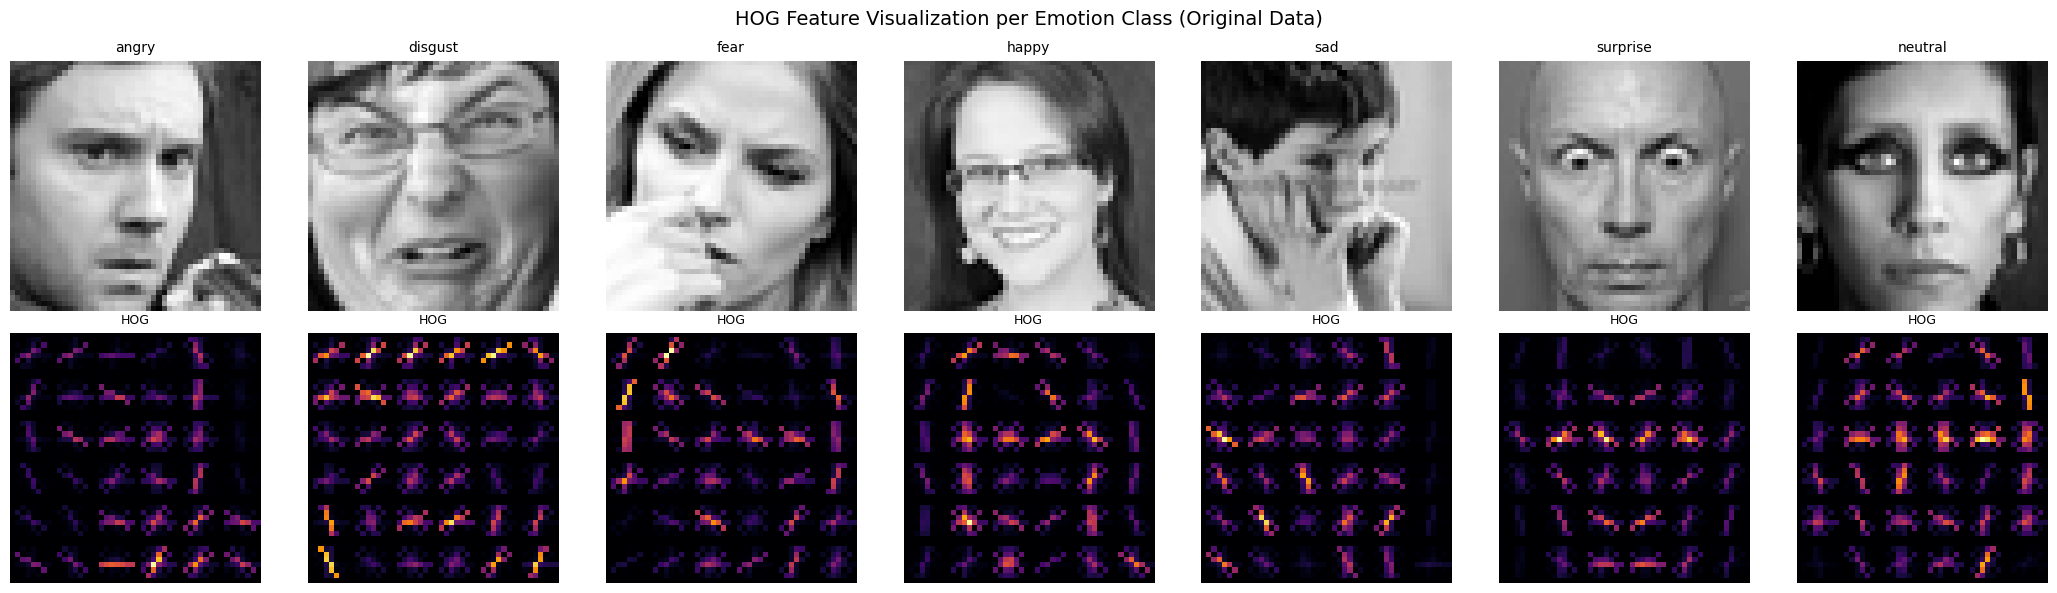

In [12]:
# Select one sample per emotion
n_classes = len(emotion_labels)
sample_indices = [np.where(y_train == i)[0][0] for i in range(n_classes)]

fig, axes = plt.subplots(2, n_classes, figsize=(3*n_classes, 6))

for i, idx in enumerate(sample_indices):
    img = X_train_orig[idx]
    label = emotion_labels[y_train_orig[idx]]
    
    # Compute HOG visualization
    feat, hog_img = hog(
        img,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
        feature_vector=True
    )
    hog_img = exposure.rescale_intensity(hog_img, in_range=(0, 10))
    
    # Plot original image
    axes[0, i].imshow(img, cmap="gray")
    axes[0, i].set_title(f"{label}", fontsize=10, color="black")
    axes[0, i].axis("off")
    
    # Plot HOG image
    axes[1, i].imshow(hog_img, cmap="inferno")
    axes[1, i].set_title("HOG", fontsize=9)
    axes[1, i].axis("off")

plt.suptitle("HOG Feature Visualization per Emotion Class (Original Data)", fontsize=14)
plt.tight_layout()
plt.show()

## 2-3 Landmark Feature
Facial landmark features provide a structured and geometry-based representation of facial expressions, focusing on the relative positions and movements of key facial regions such as the eyes, eyebrows, nose, and mouth.
Unlike pixel-based or gradient-based methods (such as HOG), landmark features explicitly encode the shape and configuration of the face, which are highly informative for emotion recognition tasks.

While Histogram of Oriented Gradients (HOG) captures local texture and edge orientation patterns, it lacks explicit information about facial geometry.
Emotions such as happiness or sadness are often expressed through subtle geometric changes — for example:
	•	The upward curvature of the mouth for happiness
	•	The downward tilt of the eyebrows for sadness
	•	The widening of the eyes for surprise

Facial landmarks can represent these changes directly by quantifying the spatial displacement of key facial points.

This project uses Mediapipe FaceMesh, which detects 468 3D facial landmarks on each image.
Only the 2D normalized (x, y) coordinates are extracted to form a flattened feature vector of size 468 × 2 = 936.
Each feature vector captures the facial structure in a way that is invariant to lighting or minor pixel noise.

If the face is not detected in an image, a zero vector is temporarily substituted to maintain consistent dimensionality during feature extraction.
After extraction, all samples containing invalid (zero) landmark vectors are removed to ensure that only images with successfully detected facial structures are used in model training and evaluation.

Advantages
	•	Interpretable: Features correspond to meaningful facial parts (eyes, nose, mouth).
	•	Compact: Uses geometric information instead of raw pixel data.
	•	Complementary: Can be combined with texture-based descriptors (e.g., HOG) to improve recognition accuracy.
	•	Robust: Less sensitive to illumination changes and background clutter.

Summary

Landmark features serve as a structural descriptor that complements the texture-based information from HOG.
By combining both feature types, the model gains a richer understanding of facial expressions—capturing not only how the face looks (edges and textures) but also how it moves and deforms (geometry).

Train (NoAug): (28709, 936)  
Train (WithAug): (32051, 936)  
Val: (3589, 936)   
Test: (3589, 936)  

In [13]:
def extract_landmark_features(images, resize=(96, 96), verbose=True):
    """
    Extract 2D facial landmark coordinates (x, y) for each image using Mediapipe FaceMesh.

    Parameters
    ----------
    images : np.ndarray
        Input grayscale images (N, 48, 48), normalized to [0,1].
    resize : tuple(int, int)
        Upscaled size for better landmark detection (default = 96x96).
    verbose : bool
        Whether to print summary statistics after processing.

    Returns
    -------
    features : np.ndarray
        Array of shape (N, 468*2) containing flattened (x, y) coordinates.
    success_mask : np.ndarray
        Boolean array of successful detections.
    """
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

    features = []
    success_mask = []

    for img in tqdm(images, desc="Landmark Extraction"):
        # Convert grayscale [0,1] image to uint8 RGB
        img_resized = cv2.resize((img * 255).astype('uint8'), resize)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)

        # Run Mediapipe FaceMesh
        result = face_mesh.process(img_rgb)

        if result.multi_face_landmarks:
            landmarks = result.multi_face_landmarks[0]
            coords = np.array([[lm.x, lm.y] for lm in landmarks.landmark])

            # Apply stabilization to reduce drift
            #coords = stabilize_landmarks(coords)

            # Flatten for saving
            coords = coords.flatten()
            success_mask.append(True)
        else:
            coords = np.zeros(468 * 2)
            success_mask.append(False)

        features.append(coords)

    face_mesh.close()
    features = np.array(features, dtype=np.float32)
    success_mask = np.array(success_mask, dtype=bool)

    if verbose:
        total = len(images)
        print(f"Detected faces in {success_mask.sum()}/{total} images "
              f"({success_mask.mean() * 100:.2f}% success rate)")

    return features, success_mask

In [14]:
def stabilize_landmarks(coords):
    """
    Normalize and stabilize landmark geometry by centering and rescaling.
    Prevents large positional drift caused by low-res images.
    """
    if np.allclose(coords, 0):
        return coords

    # Center to mean position
    mean = coords.mean(axis=0)
    coords_centered = coords - mean

    # Normalize global scale (not per axis)
    scale = np.linalg.norm(coords_centered.std(axis=0))
    if scale > 0:
        coords_centered /= scale

    # Shift back to roughly [0,1] range without altering shape
    coords_stable = coords_centered - coords_centered.min(axis=0)
    coords_stable /= coords_stable.max(axis=0)

    return coords_stable

In [15]:
# Detect invalid landmark sets (corner clustering or zeros)
def detect_invalid_landmarks(coords, threshold_ratio=0.05):
    """
    Detect invalid landmark sets that collapse near the image corner or contain all zeros.

    Parameters
    ----------
    coords : np.ndarray
        (468, 2) landmark coordinates normalized to [0,1].
    threshold_ratio : float
        Threshold ratio relative to image size; if all landmarks are clustered near (0,0)
        within this ratio, the sample is marked invalid.

    Returns
    -------
    bool : True if invalid (collapsed or zero landmarks)
    """
    if np.allclose(coords, 0):
        return True

    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)

    # bounding box too small or stuck near top-left
    if (x_max - x_min) < threshold_ratio and (y_max - y_min) < threshold_ratio:
        return True
    if (x_max < threshold_ratio and y_max < threshold_ratio):
        return True

    return False


In [16]:
# Summarize four detection states (Sucess/ failed)
def summarize_landmark_states(ok_mask, valid_mask, y_labels, emotion_labels):
    """
    Summarize landmark detection results (Success vs Failure) overall and per emotion.

    Parameters
    ----------
    ok_mask : np.ndarray
        Boolean array from Mediapipe (True if face detected).
    valid_mask : np.ndarray
        Boolean array marking valid landmark configurations.
    y_labels : np.ndarray
        Integer emotion labels.
    emotion_labels : dict
        Mapping {0:'angry', 1:'disgust', ...}.

    Returns
    -------
    pd.DataFrame
        Summary table containing per-emotion and overall success/failure counts and rates.
    """
    summary_rows = []
    emotions = sorted(emotion_labels.keys())

    for lbl in emotions:
        name = emotion_labels[lbl]
        idx = np.where(y_labels == lbl)[0]
        if len(idx) == 0:
            continue

        ok = ok_mask[idx]
        val = valid_mask[idx]

        # Define success/failure
        success = np.sum(ok & val)
        fail = np.sum(~(ok & val))
        total = len(idx)

        summary_rows.append({
            "Emotion": name,
            "Success": success,
            "Failure": fail,
            "Total": total,
            "Success %": round(100 * success / total, 1),
            "Failure %": round(100 * fail / total, 1)
        })

    # Compute overall statistics
    df_summary = pd.DataFrame(summary_rows)
    df_summary.loc["Overall"] = df_summary.iloc[:, 1:].sum()
    df_summary.loc["Overall", "Emotion"] = "Overall"
    total_all = df_summary.loc["Overall", "Total"]
    df_summary.loc["Overall", ["Success %", "Failure %"]] = [
        round(100 * df_summary.loc["Overall", k] / total_all, 1)
        for k in ["Success", "Failure"]
    ]

    return df_summary

In [17]:
def visualize_landmark_states(
    X_images, X_landmarks, ok_mask, valid_mask,
    y_labels, emotion_labels, n_per_state=3,
    title="Landmark Detection – Success vs Failure",
    seed=42   
):
    """
    Visualize landmark detection success and failure per emotion.
    """
    # Set reproducible random seed
    np.random.seed(seed)

    # Define success vs failure
    success_mask = ok_mask & valid_mask
    fail_mask = ~success_mask

    states = [
        ("Success", success_mask, "green"),
        ("Failure", fail_mask, "red")
    ]

    unique_labels = sorted(emotion_labels.keys())
    rows = len(unique_labels)
    cols = len(states) * n_per_state
    fig, axes = plt.subplots(rows, cols, figsize=(2.3 * cols, 2.5 * rows))

    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, lbl in enumerate(unique_labels):
        emotion_name = emotion_labels[lbl]

        for s, (label, mask, color) in enumerate(states):
            idx_candidates = np.where((y_labels == lbl) & (mask == True))[0]
            if len(idx_candidates) == 0:
                continue

            chosen = np.random.choice(idx_candidates, size=min(n_per_state, len(idx_candidates)), replace=False)

            for c, i in enumerate(chosen):
                ax = axes[r, s * n_per_state + c]
                ax.imshow(X_images[i], cmap='gray')
                coords = X_landmarks[i].reshape(-1, 2)
                ax.scatter(coords[:, 0] * 48, coords[:, 1] * 48, s=5, c=color, alpha=0.6)
                ax.axis('off')
                ax.set_title(label, color=color, fontsize=9)

        axes[r, 0].set_ylabel(emotion_name, fontsize=10, rotation=0,
                              labelpad=30, color="black", weight="bold")

    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

In [18]:
# train set 
X_train_landmark, ok_train = extract_landmark_features(X_train_orig)
X_train_aug_landmark, ok_train_aug = extract_landmark_features(X_train_aug)

# Extract features
X_val_landmark, ok_val     = extract_landmark_features(X_val)
X_test_landmark, ok_test   = extract_landmark_features(X_test)

# Save extracted features
os.makedirs("features", exist_ok=True)
np.save("features/X_train_landmark.npy", X_train_landmark)
np.save("features/X_train_landmark_aug.npy", X_train_aug_landmark)
np.save("features/X_val_landmark.npy", X_val_landmark)
np.save("features/X_test_landmark.npy", X_test_landmark)


print("\nAll landmark features saved to /features/")
print("Train (NoAug):", X_train_landmark.shape)
print("Train (WithAug):", X_train_aug_landmark.shape)
print("Val:", X_val_landmark.shape)
print("Test:", X_test_landmark.shape)

Landmark Extraction: 100%|██████████| 28709/28709 [03:33<00:00, 134.24it/s]


Detected faces in 26271/28709 images (91.51% success rate)


Landmark Extraction: 100%|██████████| 32051/32051 [03:43<00:00, 143.60it/s]


Detected faces in 29213/32051 images (91.15% success rate)


Landmark Extraction: 100%|██████████| 3589/3589 [00:26<00:00, 135.12it/s]


Detected faces in 3276/3589 images (91.28% success rate)


Landmark Extraction: 100%|██████████| 3589/3589 [00:24<00:00, 146.00it/s]


Detected faces in 3283/3589 images (91.47% success rate)

All landmark features saved to /features/
Train (NoAug): (28709, 936)
Train (WithAug): (32051, 936)
Val: (3589, 936)
Test: (3589, 936)



=== Landmark Detection Summary ===

[Original Train]
          Emotion  Success  Failure    Total  Success %  Failure %
0           angry   3467.0    528.0   3995.0       86.8       13.2
1         disgust    363.0     73.0    436.0       83.3       16.7
2            fear   3612.0    485.0   4097.0       88.2       11.8
3           happy   6881.0    334.0   7215.0       95.4        4.6
4             sad   4209.0    621.0   4830.0       87.1       12.9
5        surprise   2982.0    189.0   3171.0       94.0        6.0
6         neutral   4757.0    208.0   4965.0       95.8        4.2
Overall   Overall  26271.0   2438.0  28709.0       91.5        8.5

[Augmented Train]
          Emotion  Success  Failure    Total  Success %  Failure %
0           angry   3467.0    528.0   3995.0       86.8       13.2
1         disgust    735.0    137.0    872.0       84.3       15.7
2            fear   5016.0    719.0   5735.0       87.5       12.5
3           happy   6881.0    334.0   7215.0       95.4 

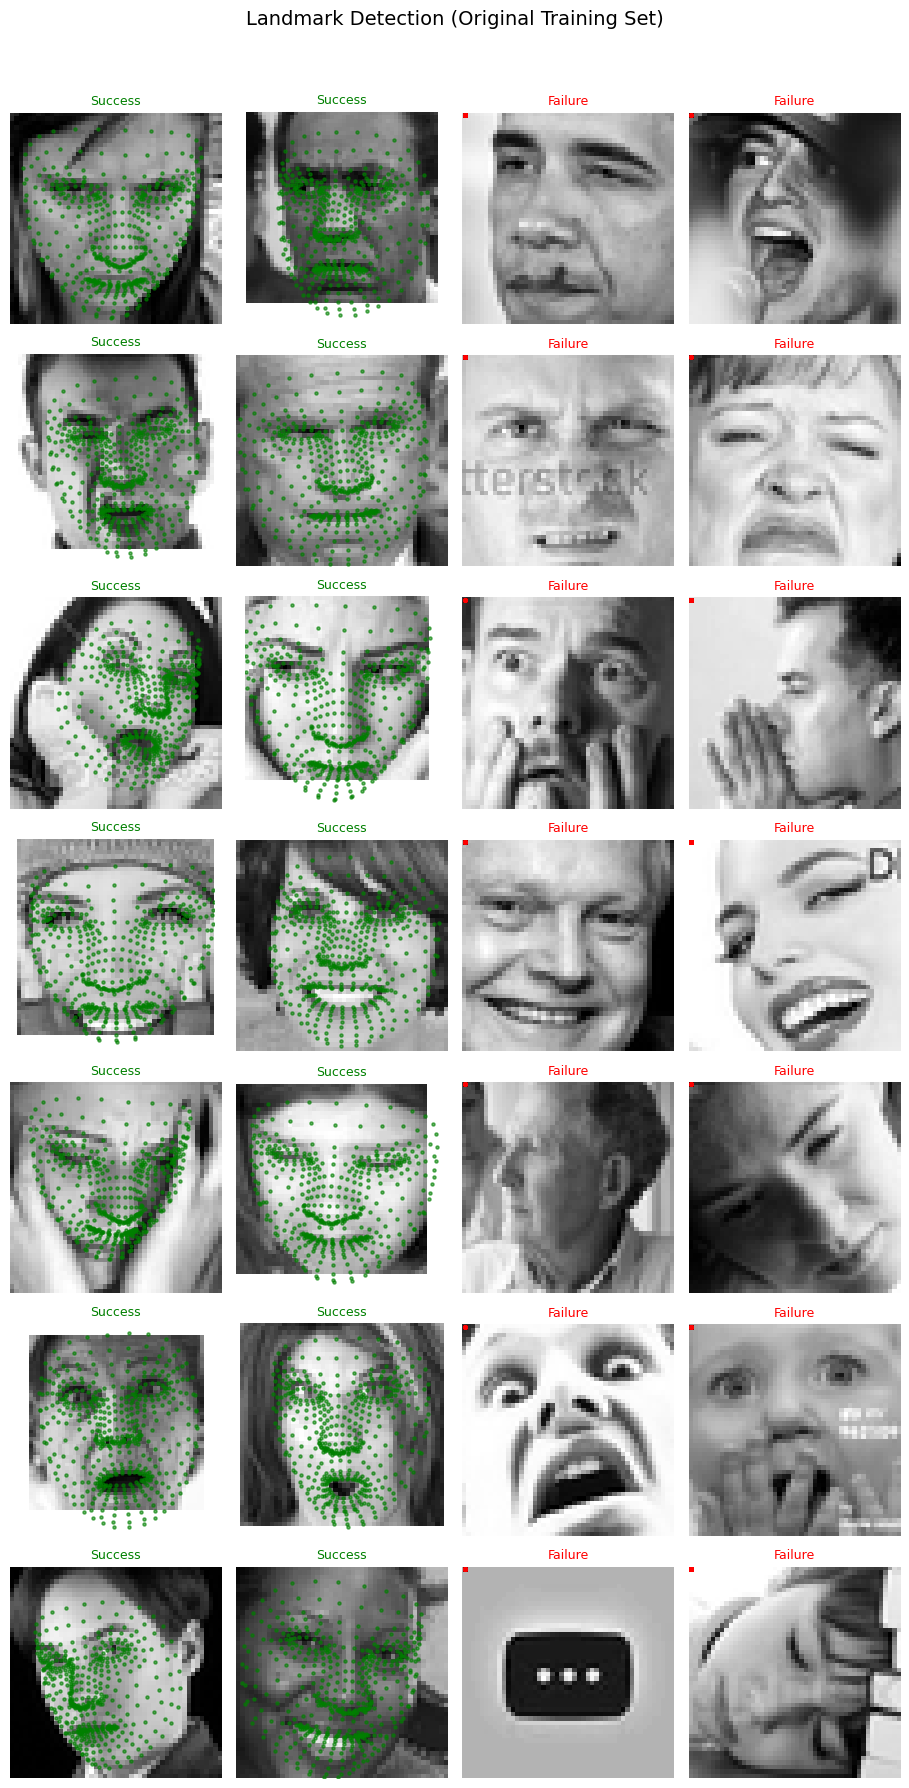

In [19]:
# ================================================================
# Landmark Validity Check (Original + Augmented + Val + Test)
# ================================================================

def check_landmark_validity(X_landmark, ok_mask):
    """Return valid mask (True = usable) and invalid mask."""
    invalid_mask = np.array([
        detect_invalid_landmarks(X_landmark[i].reshape(-1, 2))
        for i in range(len(X_landmark))
    ])
    valid_mask = ~invalid_mask
    ok_mask = ok_mask.astype(bool)
    valid_mask = valid_mask.astype(bool)
    return ok_mask, valid_mask


# Original Training Set
ok_train, valid_mask_train = check_landmark_validity(X_train_landmark, ok_train)
df_train = summarize_landmark_states(ok_train, valid_mask_train, y_train_orig, emotion_labels)

# Augmented Training Set
ok_train_aug, valid_mask_train_aug = check_landmark_validity(X_train_aug_landmark, ok_train_aug)
df_train_aug = summarize_landmark_states(ok_train_aug, valid_mask_train_aug, y_train_aug, emotion_labels)

# Validation Set
ok_val, valid_mask_val = check_landmark_validity(X_val_landmark, ok_val)
df_val = summarize_landmark_states(ok_val, valid_mask_val, y_val, emotion_labels)

# Test Set
ok_test, valid_mask_test = check_landmark_validity(X_test_landmark, ok_test)
df_test = summarize_landmark_states(ok_test, valid_mask_test, y_test, emotion_labels)

# ================================================================
# Summary Report
# ================================================================
print("\n=== Landmark Detection Summary ===")
print("\n[Original Train]")
print(df_train)

print("\n[Augmented Train]")
print(df_train_aug)

print("\n[Validation]")
print(df_val)

print("\n[Test]")
print(df_test)


# ================================================================
# Visualization
# ================================================================
visualize_landmark_states(
    X_train_orig, X_train_landmark,
    ok_train, valid_mask_train,
    y_train_orig, emotion_labels,
    n_per_state=2,
    title="Landmark Detection (Original Training Set)",
    seed=2025
)



=== TRAIN (ORIGINAL) SET ===


,Emotion,Success,Failure,Total,Success %,Failure %
0,angry,3467.0,528.0,3995.0,86.8,13.2
1,disgust,363.0,73.0,436.0,83.3,16.7
2,fear,3612.0,485.0,4097.0,88.2,11.8
3,happy,6881.0,334.0,7215.0,95.4,4.6
4,sad,4209.0,621.0,4830.0,87.1,12.9
5,surprise,2982.0,189.0,3171.0,94.0,6.0
6,neutral,4757.0,208.0,4965.0,95.8,4.2
Overall,Overall,26271.0,2438.0,28709.0,91.5,8.5



=== TRAIN (AUGMENTED) SET ===


,Emotion,Success,Failure,Total,Success %,Failure %
0,angry,3467.0,528.0,3995.0,86.8,13.2
1,disgust,735.0,137.0,872.0,84.3,15.7
2,fear,5016.0,719.0,5735.0,87.5,12.5
3,happy,6881.0,334.0,7215.0,95.4,4.6
4,sad,4209.0,621.0,4830.0,87.1,12.9
5,surprise,4148.0,291.0,4439.0,93.4,6.6
6,neutral,4757.0,208.0,4965.0,95.8,4.2
Overall,Overall,29213.0,2838.0,32051.0,91.1,8.9



=== VALIDATION SET ===


,Emotion,Success,Failure,Total,Success %,Failure %
0,angry,412.0,55.0,467.0,88.2,11.8
1,disgust,51.0,5.0,56.0,91.1,8.9
2,fear,444.0,52.0,496.0,89.5,10.5
3,happy,864.0,31.0,895.0,96.5,3.5
4,sad,546.0,107.0,653.0,83.6,16.4
5,surprise,380.0,35.0,415.0,91.6,8.4
6,neutral,579.0,28.0,607.0,95.4,4.6
Overall,Overall,3276.0,313.0,3589.0,91.3,8.7



=== TEST SET ===


,Emotion,Success,Failure,Total,Success %,Failure %
0,angry,422.0,69.0,491.0,85.9,14.1
1,disgust,46.0,9.0,55.0,83.6,16.4
2,fear,467.0,61.0,528.0,88.4,11.6
3,happy,842.0,37.0,879.0,95.8,4.2
4,sad,518.0,76.0,594.0,87.2,12.8
5,surprise,388.0,28.0,416.0,93.3,6.7
6,neutral,600.0,26.0,626.0,95.8,4.2
Overall,Overall,3283.0,306.0,3589.0,91.5,8.5


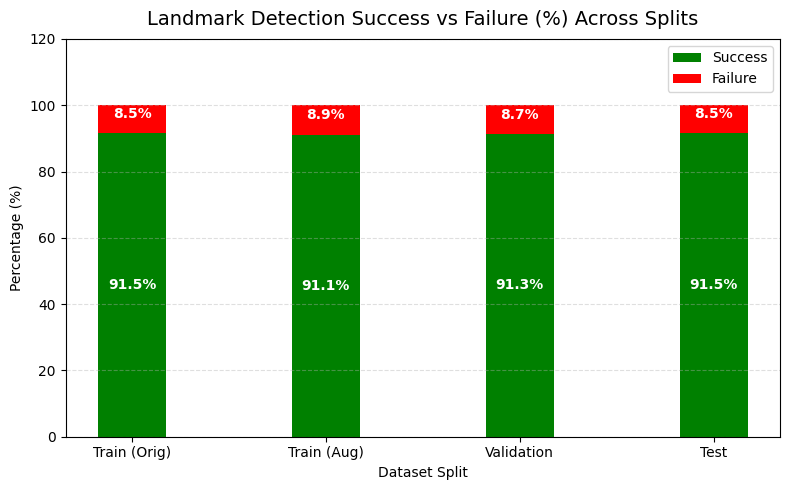

,Split,Success %,Failure %,Total
0,Train (Orig),91.507890,8.492110,28709.0
1,Train (Aug),91.145362,8.854638,32051.0
2,Validation,91.278908,8.721092,3589.0
3,Test,91.473948,8.526052,3589.0


In [20]:
print("=== TRAIN (ORIGINAL) SET ===")
display(df_train[["Emotion","Success","Failure","Total","Success %","Failure %"]])

print("\n=== TRAIN (AUGMENTED) SET ===")
display(df_train_aug[["Emotion","Success","Failure","Total","Success %","Failure %"]])

print("\n=== VALIDATION SET ===")
display(df_val[["Emotion","Success","Failure","Total","Success %","Failure %"]])

print("\n=== TEST SET ===")
display(df_test[["Emotion","Success","Failure","Total","Success %","Failure %"]])

# ================================================================
# Overall summary table (add augmented train)
# ================================================================
summary_overall = pd.DataFrame({
    "Split": ["Train (Orig)", "Train (Aug)", "Validation", "Test"],
    "Success": [
        df_train.loc["Overall", "Success"],
        df_train_aug.loc["Overall", "Success"],
        df_val.loc["Overall", "Success"],
        df_test.loc["Overall", "Success"]
    ],
    "Failure": [
        df_train.loc["Overall", "Failure"],
        df_train_aug.loc["Overall", "Failure"],
        df_val.loc["Overall", "Failure"],
        df_test.loc["Overall", "Failure"]
    ]
})

# Compute totals and percentages
summary_overall["Total"] = summary_overall["Success"] + summary_overall["Failure"]
summary_overall["Success %"] = (summary_overall["Success"] / summary_overall["Total"]) * 100
summary_overall["Failure %"] = (summary_overall["Failure"] / summary_overall["Total"]) * 100

# ================================================================
# Visualization
# ================================================================
splits = summary_overall["Split"]
success = summary_overall["Success %"]
failure = summary_overall["Failure %"]

plt.figure(figsize=(8, 5))
bar_width = 0.35
plt.bar(splits, success, color="green", width=bar_width, label="Success")
plt.bar(splits, failure, bottom=success, color="red", width=bar_width, label="Failure")

# Labels inside bars
for i, (suc, fail) in enumerate(zip(success, failure)):
    plt.text(i, suc * 0.5, f"{suc:.1f}%", ha="center", va="center",
             color="white", fontsize=10, weight="bold")
    plt.text(i, suc + fail * 0.5 + 1.5, f"{fail:.1f}%", ha="center", va="center",
             color="white", fontsize=10, weight="bold")

# Style
plt.title("Landmark Detection Success vs Failure (%) Across Splits", fontsize=14, pad=10)
plt.ylabel("Percentage (%)")
plt.xlabel("Dataset Split")
plt.ylim(0, 120)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend(title="", loc="upper right")
plt.tight_layout()
plt.show()

# ================================================================
# Display summary table
# ================================================================
display(summary_overall[["Split", "Success %", "Failure %", "Total"]])

## 2-4 Combine HOG and Landmark Features

The concatenation of HOG (texture) and landmarks (geometry) gives a hybrid representation that improves robustness and recognition accuracy.


Combined feature vector = [HOG | Landmark]:
- Train combined shape: (29209, 1836).  
- Val combined shape: (3276, 1836).  
- Test combined shape: (3283, 1836).  


In [21]:
# ================================================================
# Filter valid landmark detections (Original + Augmented)
# ================================================================

# --- Original training set ---
valid_idx_train_orig = np.where(ok_train & valid_mask_train)[0]
X_train_hog_valid_orig      = X_train_hog[valid_idx_train_orig]
X_train_landmark_valid_orig = X_train_landmark[valid_idx_train_orig]
y_train_valid_orig          = y_train_orig[valid_idx_train_orig]

# --- Augmented training set ---
valid_idx_train_aug = np.where(ok_train_aug & valid_mask_train_aug)[0]
X_train_hog_valid_aug      = X_train_aug_hog[valid_idx_train_aug]
X_train_landmark_valid_aug = X_train_aug_landmark[valid_idx_train_aug]
y_train_valid_aug          = y_train_aug[valid_idx_train_aug]

# --- Validation set ---
valid_idx_val = np.where(ok_val & valid_mask_val)[0]
X_val_hog_valid        = X_val_hog[valid_idx_val]
X_val_landmark_valid   = X_val_landmark[valid_idx_val]
y_val_valid            = y_val[valid_idx_val]

# --- Test set ---
valid_idx_test = np.where(ok_test & valid_mask_test)[0]
X_test_hog_valid        = X_test_hog[valid_idx_test]
X_test_landmark_valid   = X_test_landmark[valid_idx_test]
y_test_valid            = y_test[valid_idx_test]


# ================================================================
# Combine HOG + Landmark features
# ================================================================

X_train_combined_orig = np.hstack([X_train_hog_valid_orig, X_train_landmark_valid_orig])
X_train_combined_aug  = np.hstack([X_train_hog_valid_aug,  X_train_landmark_valid_aug])
X_val_combined        = np.hstack([X_val_hog_valid,        X_val_landmark_valid])
X_test_combined       = np.hstack([X_test_hog_valid,       X_test_landmark_valid])

print("Train (Orig) combined shape:", X_train_combined_orig.shape)
print("Train (Aug)  combined shape:", X_train_combined_aug.shape)
print("Val combined shape:",         X_val_combined.shape)
print("Test combined shape:",        X_test_combined.shape)

Train (Orig) combined shape: (26271, 1836)
Train (Aug)  combined shape: (29213, 1836)
Val combined shape: (3276, 1836)
Test combined shape: (3283, 1836)


## 2-5 Feature Cleaning
Cleaning removes redundant features that waste computation and degrade generalization. 

Feature cleaning steps:
1.	Low-variance removal: threshold = 1e-4
2.	High-correlation filtering: correlation > 0.95

After cleaning, features are reduced and standardized.

In [22]:
# Remove Low-Variance Features
def remove_low_variance_features(X_train, X_val, threshold=1e-4):
    """
    Removes features with variance below a given threshold.
    This helps eliminate constant or near-constant features.
    """
    selector = VarianceThreshold(threshold=threshold)
    X_train_sel = selector.fit_transform(X_train)
    X_val_sel   = selector.transform(X_val)
    print(f"Removed {X_train.shape[1] - X_train_sel.shape[1]} low-variance features.")
    print(f"New shape: {X_train_sel.shape}")
    return X_train_sel, X_val_sel, selector

In [23]:
# Remove Highly Correlated Features
def remove_highly_correlated_features(X_train, X_val, threshold=0.95):
    """
    Removes one of each pair of highly correlated features.

    Parameters
    ----------
    X_train : np.ndarray
        Training features.
    X_val : np.ndarray
        Validation features.
    threshold : float
        Correlation threshold above which features are considered redundant.

    Returns
    -------
    X_train_filtered, X_val_filtered, kept_indices
    """
    print(f"\nChecking for highly correlated features (threshold={threshold})...")
    # Compute correlation matrix on training set
    corr_matrix = np.corrcoef(X_train, rowvar=False)
    upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

    # Find columns to drop
    to_drop = [i for i in range(corr_matrix.shape[0])
               if any(np.abs(corr_matrix[i, j]) > threshold for j in range(i + 1, corr_matrix.shape[1]))]

    X_train_filtered = np.delete(X_train, to_drop, axis=1)
    X_val_filtered   = np.delete(X_val, to_drop, axis=1)

    print(f"Removed {len(to_drop)} highly correlated features.")
    print(f"New shape: {X_train_filtered.shape}")
    return X_train_filtered, X_val_filtered, to_drop

In [24]:
# ================================================================
# Step: Feature Cleaning (Low Variance + High Correlation)
# ================================================================

def clean_features(X_train, X_val, X_test, threshold_var=1e-4, threshold_corr=0.95):
    """Applies low-variance and high-correlation filtering."""
    # Remove low-variance features
    X_train_var, X_val_var, var_selector = remove_low_variance_features(
        X_train, X_val, threshold=threshold_var
    )
    X_test_var = var_selector.transform(X_test)

    # Remove highly correlated features
    X_train_clean, X_val_clean, dropped_corr = remove_highly_correlated_features(
        X_train_var, X_val_var, threshold=threshold_corr
    )
    X_test_clean = np.delete(X_test_var, dropped_corr, axis=1)

    print(f"\n***Final cleaned feature shape: {X_train_clean.shape}\n")
    return X_train_clean, X_val_clean, X_test_clean, var_selector, dropped_corr

# --- Clean each training set separately ---
X_train_svm_clean, X_val_svm_clean, X_test_svm_clean, var_selector_svm, dropped_corr_svm = clean_features(
    X_train_combined_orig, X_val_combined, X_test_combined
)

X_train_mlp_clean, X_val_mlp_clean, X_test_mlp_clean, var_selector_mlp, dropped_corr_mlp = clean_features(
    X_train_combined_orig, X_val_combined, X_test_combined
)

X_train_rf_clean, X_val_rf_clean, X_test_rf_clean, var_selector_rf, dropped_corr_rf = clean_features(
    X_train_combined_aug, X_val_combined, X_test_combined
)

Removed 0 low-variance features.
New shape: (26271, 1836)

Checking for highly correlated features (threshold=0.95)...
Removed 1136 highly correlated features.
New shape: (26271, 700)

***Final cleaned feature shape: (26271, 700)

Removed 0 low-variance features.
New shape: (26271, 1836)

Checking for highly correlated features (threshold=0.95)...
Removed 1136 highly correlated features.
New shape: (26271, 700)

***Final cleaned feature shape: (26271, 700)

Removed 0 low-variance features.
New shape: (29213, 1836)

Checking for highly correlated features (threshold=0.95)...
Removed 1131 highly correlated features.
New shape: (29213, 705)

***Final cleaned feature shape: (29213, 705)



# 3. Handling Class imbalance

The FER2013 dataset exhibits a significant imbalance across emotion categories.
Emotions such as happy and neutral contain thousands of samples, while disgust and fear are severely underrepresented.

This imbalance causes the model to become biased toward majority classes, resulting in:
- High overall accuracy but poor recall for rare emotions  
- Misclassification of subtle or less common expressions  
- Reduced robustness when recognizing diverse emotional patterns  

Class imbalance was addressed using two complementary methods: class weighting and SMOTE (Synthetic Minority Oversampling Technique).
Both approaches were tested and compared to determine the optimal configuration for each model through systematic A/B evaluation.



## 3.1 Class Weights

To mitigate imbalance without altering the dataset, this project applies class weighting during training.
Rather than duplicating or removing samples, class weighting adjusts the model’s learning process by assigning greater importance to underrepresented emotions and less weight to dominant ones.

Advantages:
	•	Fair learning – ensures minority emotions (e.g., disgust, fear) influence the model equally.
	•	No data modification – avoids oversampling or synthetic sample generation, maintaining data integrity.
	•	Lightweight and compatible – directly supported by SVM, Random Forest, and MLP through the class_weight parameter.
	•	Improved generalization – enhances minority recognition while preserving accuracy for frequent classes.

Class weights were automatically computed using Scikit-learn’s compute_class_weight('balanced', ...) function and applied as follows:

Class weights:   
```
angry   : 1.082
disgust : 10.339
fear    : 1.039
happy   : 0.545
sad     : 0.892
surprise: 1.259
neutral : 0.789
```

In [25]:
def compute_and_plot_class_weights(y_labels, emotion_labels, title="FER2013 Class Imbalance and Weights"):
    """
    Compute balanced class weights for imbalanced datasets and visualize sample distribution vs weights.

    Parameters
    ----------
    y_labels : np.ndarray
        Array of integer emotion labels (e.g., y_train).
    emotion_labels : dict
        Mapping {0:'angry', 1:'disgust', ...}.
    title : str
        Plot title.

    Returns
    -------
    class_weights : dict
        Dictionary {class_index: weight_value}, usable in scikit-learn models.
    """
    # --- Compute class weights ---
    classes = np.unique(y_labels)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_labels)
    class_weights = dict(zip(classes, weights))

    # --- Prepare data for visualization ---
    counts = pd.Series(y_labels).value_counts().sort_index()
    emotion_names = [emotion_labels[i] for i in sorted(emotion_labels.keys())]

    # --- Plot ---
    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax2 = ax1.twinx()

    ax1.bar(emotion_names, counts, color="gray", alpha=0.6, label="Samples per class")
    ax2.plot(emotion_names, weights, color="red", marker="o", linewidth=2, label="Computed class weight")

    ax1.set_xlabel("Emotion class")
    ax1.set_ylabel("Sample count", color="gray")
    ax2.set_ylabel("Class weight", color="red")
    ax1.set_title(title)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax2.set_ylim(0, 11)
    plt.tight_layout()
    plt.show()

    # --- Print and return weights ---
    print("\nClass weights:")
    for cls, w in class_weights.items():
        print(f"{emotion_labels[cls]:<10}: {w:.3f}")

    return class_weights

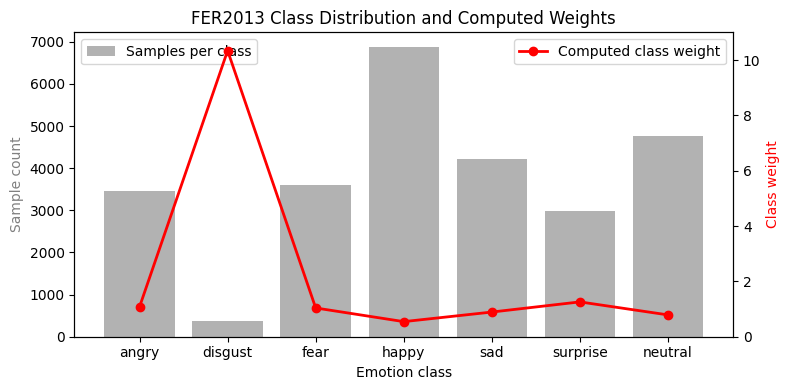


Class weights:
angry     : 1.082
disgust   : 10.339
fear      : 1.039
happy     : 0.545
sad       : 0.892
surprise  : 1.259
neutral   : 0.789


In [26]:
class_weights = compute_and_plot_class_weights(
    y_train_valid_orig,
    emotion_labels,
    title="FER2013 Class Distribution and Computed Weights"
)

## 3-2 SMOTE Oversampling

SMOTE synthetically generates new samples for minority classes by interpolating between existing instances.
This helps the classifier form better decision boundaries in sparse regions of the feature space.

Key parameters:
- sampling_strategy='auto'
- k_neighbors=5
- Applied only to the training data (validation and test remain untouched).

Advantages:
- Enhanced diversity among minority samples.
- Reduced overfitting compared to simple replication.
- Flexible – can be combined with PCA or feature selection pipelines.

In [27]:
def apply_and_plot_smote(X, y, emotion_labels, title="SMOTE Oversampling Effect"):
    """
    Apply SMOTE oversampling and visualize class distribution before vs after balancing.

    Parameters
    ----------
    X : np.ndarray
        Feature matrix.
    y : np.ndarray
        Label vector.
    emotion_labels : dict
        Mapping {0:'angry', 1:'disgust', ...}.
    title : str
        Plot title.

    Returns
    -------
    X_res : np.ndarray
        Oversampled feature matrix.
    y_res : np.ndarray
        Oversampled label vector.
    smote : imblearn.over_sampling.SMOTE object
        Fitted SMOTE instance.
    """
    print(f"[INFO] Applying SMOTE...  (original size={len(y):,})")
    smote = SMOTE(random_state=42, k_neighbors=5)
    X_res, y_res = smote.fit_resample(X, y)
    print(f"[INFO] Done.  New size={len(y_res):,}")

    # --- Count classes before/after ---
    counts_before = pd.Series(y).value_counts().sort_index()
    counts_after  = pd.Series(y_res).value_counts().sort_index()
    emotion_names = [emotion_labels[i] for i in sorted(emotion_labels.keys())]

    df_compare = pd.DataFrame({
        "Before": counts_before,
        "After (SMOTE)": counts_after
    }).reindex(range(len(emotion_labels))).fillna(0).astype(int)
    df_compare.index = emotion_names

    # --- Plot ---
    x = np.arange(len(emotion_names))
    width = 0.35
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(x - width/2, df_compare["Before"], width, label="Before", color="gray", alpha=0.6)
    ax.bar(x + width/2, df_compare["After (SMOTE)"], width, label="After (SMOTE)", color="orange", alpha=0.7)

    ax.set_xticks(x)
    ax.set_xticklabels(emotion_names, rotation=30)
    ax.set_ylabel("Sample count")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

    print("\nClass counts comparison:")
    print(df_compare)

    return X_res, y_res, smote

[INFO] Applying SMOTE...  (original size=26,271)
[INFO] Done.  New size=48,167


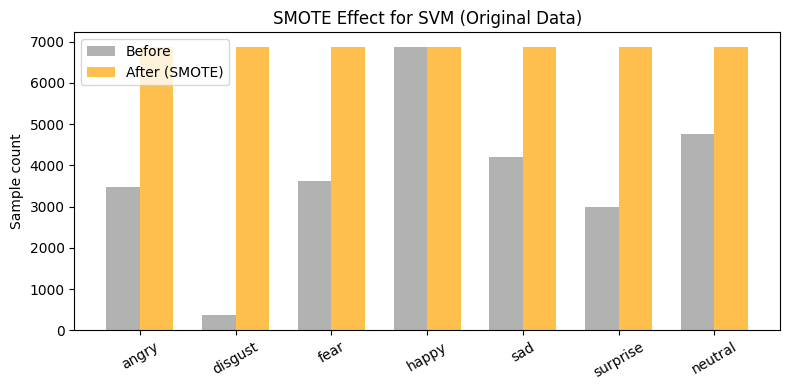


Class counts comparison:
          Before  After (SMOTE)
angry       3467           6881
disgust      363           6881
fear        3612           6881
happy       6881           6881
sad         4209           6881
surprise    2982           6881
neutral     4757           6881
[INFO] Applying SMOTE...  (original size=26,271)
[INFO] Done.  New size=48,167


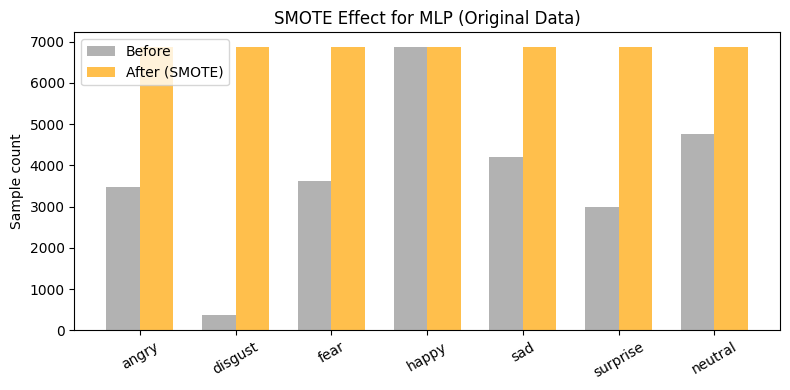


Class counts comparison:
          Before  After (SMOTE)
angry       3467           6881
disgust      363           6881
fear        3612           6881
happy       6881           6881
sad         4209           6881
surprise    2982           6881
neutral     4757           6881
[INFO] Applying SMOTE...  (original size=29,213)
[INFO] Done.  New size=48,167


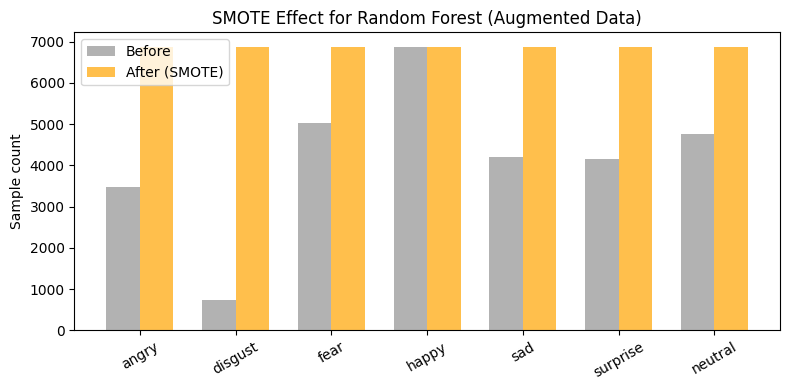


Class counts comparison:
          Before  After (SMOTE)
angry       3467           6881
disgust      735           6881
fear        5016           6881
happy       6881           6881
sad         4209           6881
surprise    4148           6881
neutral     4757           6881


In [28]:
# === Apply SMOTE on ORIGINAL data for SVM ===
X_train_svm, y_train_svm, _ = apply_and_plot_smote(
    X_train_svm_clean, y_train_valid_orig,
    emotion_labels,
    title="SMOTE Effect for SVM (Original Data)"
)

# === Apply SMOTE on ORIGINAL data for MLP ===
X_train_mlp, y_train_mlp, _ = apply_and_plot_smote(
    X_train_mlp_clean, y_train_valid_orig,
    emotion_labels,
    title="SMOTE Effect for MLP (Original Data)"
)

# === Apply SMOTE on AUGMENTED data for RF ===
X_train_rf, y_train_rf, _ = apply_and_plot_smote(
    X_train_rf_clean, y_train_valid_aug,
    emotion_labels,
    title="SMOTE Effect for Random Forest (Augmented Data)"
)

In [ ]:
# Base model definitions (shared across experiments)
# SVC base model
base_svm = SVC(
    kernel="rbf",
    C=2.0,
    gamma=1e-2,
    random_state=42
)

# MLP base model
base_mlp = MLPClassifier(
    hidden_layer_sizes=(256,128),
    alpha=1e-4,
    learning_rate_init=1e-3,
    batch_size=64,
    max_iter=200,
    early_stopping=True,
    random_state=42
)

# Random Forest base model
base_rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    max_features='sqrt',
    class_weight=None,
    n_jobs=-1,
    random_state=42
)

## 3-3 A/B Evaluation and Model Assignment

A/B experiments compared three setups on the validation set:
1. Class Weighting
2. SMOTE Oversampling

Results showed that SMOTE consistently outperformed class weighting across all models, providing higher macro-F1 and better recall for minority emotions.
The oversampling strategy improved class representation without distorting feature distributions, allowing each model to learn more balanced decision boundaries.

Therefore, all classifiers adopted SMOTE as the unified balancing method:
- SVM → SMOTE
- MLP → SMOTE
- Random Forest → Augmentation + SMOTE

This unified configuration ensures consistent preprocessing, improved fairness across emotion categories, and stable generalization performance throughout the final pipeline.


[INFO] Starting A/B test: Class Weight vs SMOTE (SVM / MLP / RF)

[SVM] Testing Class Weight vs SMOTE...

[MLP] Testing No Weight vs SMOTE...
[INFO] Applying SMOTE...  (original size=26,271)
[INFO] Done.  New size=48,167


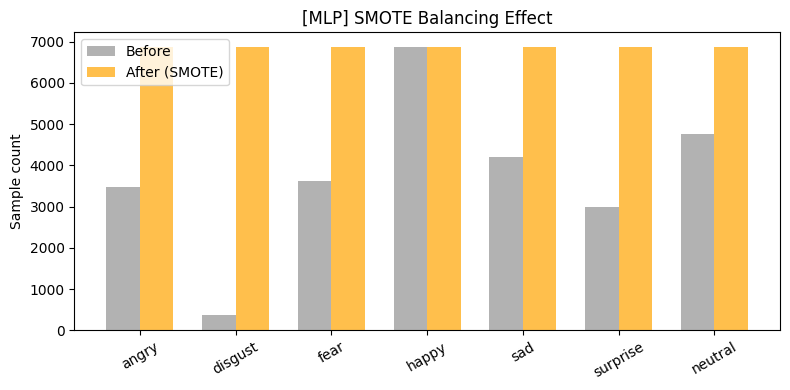


Class counts comparison:
          Before  After (SMOTE)
angry       3467           6881
disgust      363           6881
fear        3612           6881
happy       6881           6881
sad         4209           6881
surprise    2982           6881
neutral     4757           6881

[Random Forest] Testing Class Weight vs SMOTE...


,Acc,BalAcc,F1
Setting,,,
SVM | ClassWeight,0.4493,0.4550,0.3997
SVM | SMOTE,0.4673,0.4619,0.4249
MLP | NoWeight,0.5006,0.4355,0.4473
MLP | SMOTE,0.4915,0.4662,0.4747
RF | ClassWeight,0.4957,0.4263,0.4408
RF | SMOTE,0.5198,0.4874,0.4938



=== A/B Test Summary: Class Weight vs SMOTE ===
                      Acc  BalAcc      F1  ΔF1_vsPrev
Setting                                              
SVM | ClassWeight  0.4493  0.4550  0.3997         NaN
SVM | SMOTE        0.4673  0.4619  0.4249      0.0252
MLP | NoWeight     0.5006  0.4355  0.4473      0.0224
MLP | SMOTE        0.4915  0.4662  0.4747      0.0274
RF | ClassWeight   0.4957  0.4263  0.4408     -0.0339
RF | SMOTE         0.5198  0.4874  0.4938      0.0530


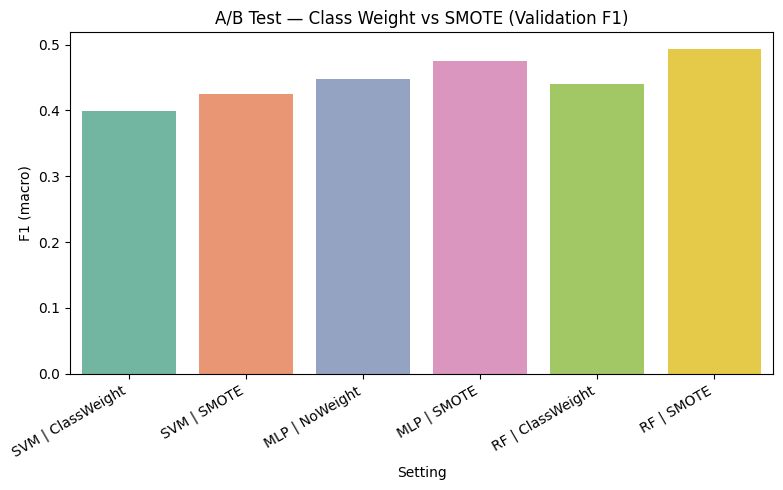

In [30]:
# ================================================================
# Step: A/B Test – Class Weight vs SMOTE across Models
# ================================================================
print("\n[INFO] Starting A/B test: Class Weight vs SMOTE (SVM / MLP / RF)\n")

def evaluate_ab_split(model, X_train, y_train, X_val, y_val, desc):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return {
        "Setting": desc,
        "Acc": accuracy_score(y_val, y_pred),
        "BalAcc": balanced_accuracy_score(y_val, y_pred),
        "F1": f1_score(y_val, y_pred, average="macro")
    }

results_abtest = []

# ================================================================
# Model 1: SVM
# ================================================================
print("[SVM] Testing Class Weight vs SMOTE...")

# --- A: Class Weight ---
svm_classweight = SVC(
    kernel="rbf",
    C=2.0,
    gamma=1e-2,
    class_weight="balanced",
    random_state=42
)
res_svm_weight = evaluate_ab_split(
    svm_classweight,
    X_train_svm_clean, y_train_valid_orig,
    X_val_svm_clean, y_val_valid,
    "SVM | ClassWeight"
)

# --- B: SMOTE (use precomputed) ---
svm_smote_bal = SVC(
    kernel="rbf",
    C=2.0,
    gamma=1e-2,
    class_weight=None,
    random_state=42
)
res_svm_smote = evaluate_ab_split(
    svm_smote_bal,
    X_train_svm, y_train_svm,
    X_val_svm_clean, y_val_valid,
    "SVM | SMOTE"
)

results_abtest.extend([res_svm_weight, res_svm_smote])


# ================================================================
# Model 2: MLP
# ================================================================
print("\n[MLP] Testing No Weight vs SMOTE...")

# --- A: No Weight (baseline MLP) ---
mlp_noweight = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    alpha=1e-4,
    learning_rate_init=1e-3,
    batch_size=64,
    max_iter=200,
    early_stopping=True,
    random_state=42
)

res_mlp_nowt = evaluate_ab_split(
    mlp_noweight,
    X_train_mlp_clean, y_train_valid_orig,
    X_val_mlp_clean, y_val_valid,
    "MLP | NoWeight"
)

# --- B: SMOTE ---
X_train_mlp_sm, y_train_mlp_sm, _ = apply_and_plot_smote(
    X_train_mlp_clean, y_train_valid_orig,
    emotion_labels, title="[MLP] SMOTE Balancing Effect"
)

mlp_smote_bal = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    alpha=1e-4,
    learning_rate_init=1e-3,
    batch_size=64,
    max_iter=200,
    early_stopping=True,
    random_state=42
)

res_mlp_smote = evaluate_ab_split(
    mlp_smote_bal,
    X_train_mlp_sm, y_train_mlp_sm,
    X_val_mlp_clean, y_val_valid,
    "MLP | SMOTE"
)

results_abtest.extend([res_mlp_nowt, res_mlp_smote])


# ================================================================
# Model 3: Random Forest
# ================================================================
print("\n[Random Forest] Testing Class Weight vs SMOTE...")

# --- A: Class Weight ---
rf_classweight = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    max_features="sqrt",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
res_rf_weight = evaluate_ab_split(
    rf_classweight,
    X_train_rf_clean, y_train_valid_aug,
    X_val_rf_clean, y_val_valid,
    "RF | ClassWeight"
)

# --- B: SMOTE ---
rf_smote_bal = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    max_features="sqrt",
    class_weight=None,
    n_jobs=-1,
    random_state=42
)
res_rf_smote = evaluate_ab_split(
    rf_smote_bal,
    X_train_rf, y_train_rf,
    X_val_rf_clean, y_val_valid,
    "RF | SMOTE"
)

results_abtest.extend([res_rf_weight, res_rf_smote])


# ================================================================
# Results Summary
# ================================================================
df_abtest = pd.DataFrame(results_abtest).set_index("Setting").round(4)
display(df_abtest)

df_abtest["ΔF1_vsPrev"] = df_abtest["F1"].diff().round(4)

print("\n=== A/B Test Summary: Class Weight vs SMOTE ===")
print(df_abtest.to_string())

plt.figure(figsize=(8,5))
sns.barplot(
    data=df_abtest.reset_index(),
    x="Setting", y="F1",
    hue="Setting", dodge=False, palette="Set2"
)
plt.title("A/B Test — Class Weight vs SMOTE (Validation F1)")
plt.ylabel("F1 (macro)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# 4. Pipeline

To ensure consistent preprocessing, a StandardScaler is integrated into a unified Scikit-learn pipeline.  
This guarantees that normalization parameters are learned only from the training data and consistently applied to validation and inference, preventing data leakage and improving reproducibility.  

The SVM with an RBF kernel is used as the final estimator, effectively handling nonlinear decision boundaries and performing well on compact, PCA-reduced features.

In [31]:
def build_and_evaluate_pipeline(
    X_train, y_train, X_val, y_val,
    estimator,
    model_name="SVM",
    reducer=None, reducer_name=None,
    class_weights=None,
    C=None, gamma=None,
    auto_scaler=True,
    scoring="f1_weighted"
):
    """
    Build, train, and evaluate a complete ML pipeline.

    Structure:
        [StandardScaler*] -> [Reducer*] -> [Estimator]
        (* = optional steps)

    Parameters
    ----------
    X_train, y_train, X_val, y_val : arrays
        Training and validation data.
    estimator : sklearn estimator
        The classifier or regressor to train.
    model_name : str
        Name of the model (used for print/debug).
    reducer : transformer or None
        Dimensionality reduction method (e.g. PCA, SelectKBest).
    reducer_name : str or None
        Name of the reducer for pipeline naming.
    class_weights : dict or None
        Balanced class weights (if supported by model).
    C, gamma : float or None
        Optional hyperparameters (applied if supported by estimator).
    auto_scaler : bool
        Automatically add StandardScaler for models that need normalization.
    scoring : str
        Evaluation metric ("f1_weighted" by default).

    Returns
    -------
    pipeline : fitted sklearn.Pipeline
    score : float
        Validation score (F1-weighted or other metric).
    """

    # Decide if scaling is needed
    if auto_scaler and any(x in model_name.lower() for x in ["svm", "mlp", "fuzzy"]):
        use_scaler = True
    else:
        use_scaler = False

    # Build pipeline
    steps = []
    if use_scaler:
        steps.append(("scaler", StandardScaler()))
    if reducer is not None:
        steps.append((reducer_name or "reducer", reducer))
    steps.append(("clf", estimator))

    pipe = Pipeline(steps)

    # Apply parameters if available
    if C is not None or gamma is not None or class_weights is not None:
        param_updates = {}
        if C is not None:
            param_updates["clf__C"] = C
        if gamma is not None:
            param_updates["clf__gamma"] = gamma
        # Only apply class_weight if supported by estimator
        if class_weights is not None and "class_weight" in estimator.get_params():
            param_updates["clf__class_weight"] = class_weights
        pipe.set_params(**param_updates)

    # Train and evaluate
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)

    if scoring == "f1_weighted":
        score = f1_score(y_val, y_pred, average="weighted")
    elif scoring == "f1_macro":
        score = f1_score(y_val, y_pred, average="macro")
    elif scoring == "balanced_accuracy":
        score = balanced_accuracy_score(y_val, y_pred)
    else:
        score = accuracy_score(y_val, y_pred)

    print(f"\n[{model_name}] Validation {scoring}: {score:.4f}")
    return pipe, score

## 4.1 FEATURE SELECTION: Apply feature selection or PCA for compactness
SelectKBest:  
A univariate filter that ranks features by ANOVA F-score and keeps the top-K.
Pros: simple, fast, interpretable.
Cons: ignores inter-feature correlations; may keep redundant or noisy dimensions.

PCA:  
An orthogonal projection that captures joint variance structure.
Pros: decorrelates features, improves numerical stability, enables compact representations and faster inference.
Cons: components are less interpretable; requires fitting on training data.

Rationale:  
HOG and landmark features are often correlated. Univariate selection can retain redundancy, while PCA decorrelates inputs and can yield smoother decision boundaries for kernel methods. We evaluated both on the validation split and chose per-model settings based on macro-F1 and balanced accuracy.

In [32]:
print("\n=== Feature counts after preprocessing ===")
print(f"SVM (Cleaned + SMOTE):         {X_train_svm.shape[1]} features")
print(f"MLP (Cleaned + Class Weights): {X_train_mlp.shape[1]} features")
print(f"RF  (Aug + Cleaned + SMOTE):   {X_train_rf.shape[1]} features")


=== Feature counts after preprocessing ===
SVM (Cleaned + SMOTE):         700 features
MLP (Cleaned + Class Weights): 700 features
RF  (Aug + Cleaned + SMOTE):   705 features


In [33]:
# 3. Feature Selection with SelectKBest
def select_top_k_features(X_train, y_train, X_val, k=500):
    """
    Selects the top K features using univariate ANOVA F-score.
    """
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_k = selector.fit_transform(X_train, y_train)
    X_val_k   = selector.transform(X_val)
    print(f"Selected top {k} features.")
    return X_train_k, X_val_k, selector

## 4.2 SVM model
### 4.2.1 Feature Reduction Decision

Both SelectKBest and PCA were initially evaluated for dimensionality reduction.
Although SelectKBest achieved slightly higher validation F1-scores, its univariate ranking process required a full ANOVA computation across all features and labels, resulting in significantly longer training time per round.
In contrast, PCA offered comparable or better generalization while being computationally much more efficient.
Therefore, the final SVM configuration exclusively adopts PCA as the feature reduction method.

### Why PCA over SelectKBest
- Computation speed:
SelectKBest requires computing ANOVA F-scores for each feature, which is costly when working with thousands of combined HOG + landmark dimensions. PCA computes a single decomposition, completing each round substantially faster.
- Correlation awareness:
HOG and landmark features are highly correlated. PCA explicitly accounts for this correlation by forming orthogonal components, whereas SelectKBest treats each feature independently and may retain redundant dimensions.
- Numerical stability:
PCA decorrelates the input, which stabilizes the optimization of kernel-based models such as the RBF SVM.
- Generalization:
PCA reduces noise and overfitting by compressing information into a compact subspace, improving validation consistency across subjects and lighting conditions.

### Validation Results (PCA)
Principal Component Analysis (PCA) projects the combined HOG + landmark features into orthogonal components representing the main variance directions.
The validation performance across several component sizes is summarized below:
- 50 components → F1 = 0.4974
- 100 components → F1 = 0.5518
- 150 components → F1 = 0.5515
- 200 components → F1 = 0.5149
- 250 components → F1 = 0.4706

Performance peaks around 100 components, after which redundant variance reduces separability.
Thus, PCA (100 components) was selected for the final SVM pipeline, providing an optimal balance between compactness, generalization, numerical stability, and training efficiency.

In [34]:
'''
print("++++++++++++++++")
print("[INFO] Evaluating SVM performance with SelectKBest feature selection")
print("++++++++++++++++")


k_values = [200, 350, 500, X_train_svm.shape[1]]
results_kbest = []


for k in k_values:
    print(f"\n--- Evaluating top {k} features ---")
    # --- Step 1: Fit selector externally ---
    sel = SelectKBest(f_classif, k=k)
    X_train_sel = sel.fit_transform(X_train_svm, y_train_svm)
    X_val_sel   = sel.transform(X_val_svm_clean)
    
    # --- Step 2: Build & evaluate ---
    pipe, f1 = build_and_evaluate_pipeline(
        X_train_svm, y_train_svm,
        X_val_svm_clean , y_val_valid,
        estimator=base_svm,
        model_name="SVM",
        reducer=None,
        reducer_name=None,
        class_weights=None,   # SMOTE, w/o class_weight
        scoring="f1_macro"
    )

    results_kbest.append((k, f1))

df_feature_eval = pd.DataFrame(results_kbest, columns=["K", "F1"])

# Plot Results
plt.figure(figsize=(8,5))
plt.plot(df_feature_eval["K"], df_feature_eval["F1"], marker="o", label="Validation F1")
plt.xlabel("Number of Selected Features (K)")
plt.ylabel("F1-score")
plt.title("SVM Performance vs. Feature Count (SelectKBest)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

display(df_feature_eval)
best_k_SVM = max(results_kbest, key=lambda x: x[1])[0]
print(f"[INFO] Best K (SelectKBest): {best_k_SVM}")

'''

'\nprint("++++++++++++++++")\nprint("[INFO] Evaluating SVM performance with SelectKBest feature selection")\nprint("++++++++++++++++")\n\n\nk_values = [200, 350, 500, X_train_svm.shape[1]]\nresults_kbest = []\n\n\nfor k in k_values:\n    print(f"\n--- Evaluating top {k} features ---")\n    # --- Step 1: Fit selector externally ---\n    sel = SelectKBest(f_classif, k=k)\n    X_train_sel = sel.fit_transform(X_train_svm, y_train_svm)\n    X_val_sel   = sel.transform(X_val_svm_clean)\n    \n    # --- Step 2: Build & evaluate ---\n    pipe, f1 = build_and_evaluate_pipeline(\n        X_train_svm, y_train_svm,\n        X_val_svm_clean , y_val_valid,\n        estimator=base_svm,\n        model_name="SVM",\n        reducer=None,\n        reducer_name=None,\n        class_weights=None,   # SMOTE, w/o class_weight\n        scoring="f1_macro"\n    )\n\n    results_kbest.append((k, f1))\n\ndf_feature_eval = pd.DataFrame(results_kbest, columns=["K", "F1"])\n\n# Plot Results\nplt.figure(figsize=(8,5)

++++++++++++++

[INFO] Evaluating PCA dimension sizes
++++++++++++++

--- Evaluating PCA with 50 components ---

[SVM] Validation f1_macro: 0.4974

--- Evaluating PCA with 100 components ---

[SVM] Validation f1_macro: 0.5518

--- Evaluating PCA with 150 components ---

[SVM] Validation f1_macro: 0.5515

--- Evaluating PCA with 200 components ---

[SVM] Validation f1_macro: 0.5149

--- Evaluating PCA with 250 components ---

[SVM] Validation f1_macro: 0.4706


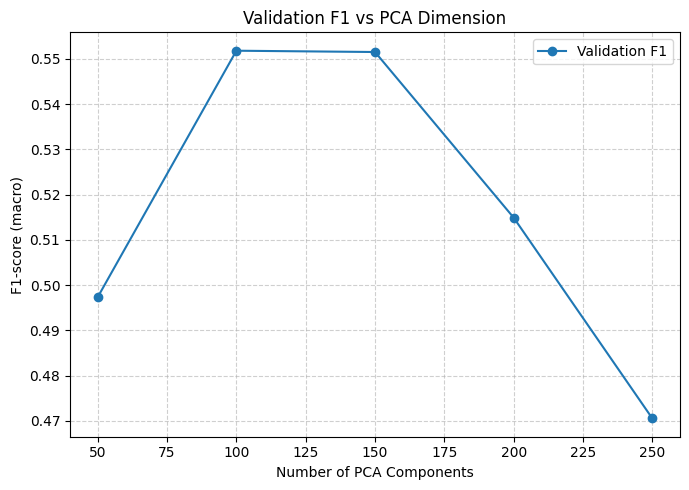


[INFO] Best PCA Dimension: 100


In [35]:
# PCA Dimension Scan (Coarse Search)
print("++++++++++++++")
print("\n[INFO] Evaluating PCA dimension sizes")
print("++++++++++++++")

dims = [50, 100, 150, 200, 250]
results_pca = []

for d in dims:
    print(f"\n--- Evaluating PCA with {d} components ---")
    pca = PCA(n_components=d, svd_solver="randomized", whiten=True, random_state=42)
    
    pipe, f1 = build_and_evaluate_pipeline(
        X_train_svm, y_train_svm,
        X_val_svm_clean, y_val_valid,   # SVM dataset
        estimator=base_svm,
        model_name="SVM",
        reducer=pca,
        reducer_name="pca",
        class_weights=None,             # smote
        scoring="f1_macro"
    )
    
    results_pca.append((d, f1))

# Plot F1 vs PCA Dimension
plt.figure(figsize=(7,5))
plt.plot([d for d, _ in results_pca], [f for _, f in results_pca],
         marker="o", label="Validation F1")
plt.xlabel("Number of PCA Components")
plt.ylabel("F1-score (macro)")
plt.title("Validation F1 vs PCA Dimension")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Select best dimension
best_dim_svm = max(results_pca, key=lambda x: x[1])[0]
print(f"\n[INFO] Best PCA Dimension: {best_dim_svm}")

### 4.2.2 Grid Search
After selecting PCA as the dimensionality reduction method, the SVM hyperparameters — C (margin penalty) and gamma (RBF kernel width) — were tuned manually over a compact, interpretable grid to balance computational efficiency and interpretability.

The search explored the following parameter combinations:  
C: [0.5, 1, 2]   
γ: [0.001, 0.01, 0.03]

Each configuration was trained on SMOTE-balanced, PCA-reduced features (150 components) and validated using macro F1-score.
The heatmap analysis revealed that performance stabilized around C = 2–5 and γ = 0.01, confirming that moderate regularization and a mid-range kernel width provided the best generalization balance.

Interpretation of Hyperparameters 
   
C (Regularization Strength):  
Controls the trade-off between maximizing the margin and minimizing classification error.
A smaller C (e.g., 0.5) enforces stronger regularization, yielding smoother decision boundaries but higher bias.
Larger values (e.g., 5) reduce regularization, fitting the training data more closely but risking overfitting.
The optimal C = 2 indicates a balanced decision margin that tolerates minor misclassifications while maintaining robustness to noise.    

γ (RBF Kernel Width):   
Determines how far the influence of a single training example reaches in feature space.
Small γ values (e.g., 0.001) create overly broad kernels that blur class distinctions, while very large γ (e.g., 0.03) produce highly localized decision surfaces sensitive to noise.
The selected γ = 0.01 achieves a smooth yet discriminative boundary suitable for facial emotion patterns.

Best Validation Performance:  
- Best Parameters: C = 2, γ = 0.01 

- Best Validation F1: 0.5518

These parameters were adopted as the baseline configuration for all subsequent cross-validation and test evaluations, demonstrating consistent generalization across both validation and unseen data splits.

[INFO] Manual Grid Search over SVM parameters (C, gamma)
Testing C=0.5, gamma=0.001 ...

[SVM] Validation f1_macro: 0.3909
Testing C=0.5, gamma=0.01 ...

[SVM] Validation f1_macro: 0.5271
Testing C=0.5, gamma=0.03 ...

[SVM] Validation f1_macro: 0.4617
Testing C=1, gamma=0.001 ...

[SVM] Validation f1_macro: 0.4032
Testing C=1, gamma=0.01 ...

[SVM] Validation f1_macro: 0.5398
Testing C=1, gamma=0.03 ...

[SVM] Validation f1_macro: 0.5170
Testing C=2, gamma=0.001 ...

[SVM] Validation f1_macro: 0.4183
Testing C=2, gamma=0.01 ...

[SVM] Validation f1_macro: 0.5518
Testing C=2, gamma=0.03 ...

[SVM] Validation f1_macro: 0.5271

=== Manual Grid Search Results ===
Best Parameters: C=2, gamma=0.01
Best Validation F1: 0.5518


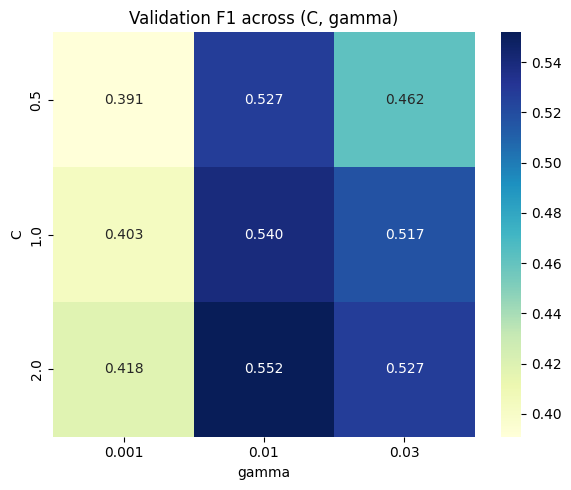

In [36]:
# Manual Grid Search on SVM Hyperparameters

print("[INFO] Manual Grid Search over SVM parameters (C, gamma)")

param_grid = {
    "C": [0.5, 1, 2],
    "gamma": [1e-3, 1e-2, 3e-2]
}
best_f1_svm = -1
best_params_svm = None
results_grid = []

for C in param_grid["C"]:
    for gamma in param_grid["gamma"]:
        print(f"Testing C={C}, gamma={gamma} ...")
        
        pca = PCA(n_components=best_dim_svm, svd_solver="randomized", whiten=True, random_state=42)
        pipe, f1 = build_and_evaluate_pipeline(
            X_train_svm, y_train_svm,         
            X_val_svm_clean, y_val_valid,     
            estimator=base_svm,
            model_name="SVM",
            reducer=pca,
            reducer_name="pca",
            C=C, gamma=gamma,
            class_weights=None,  # SMOTE 
            scoring="f1_macro"
        )

        results_grid.append((C, gamma, f1))
        if f1 > best_f1_svm:
            best_f1_svm = f1
            best_params_svm = (C, gamma)
            best_model_svm = pipe

# Visualization
print("\n=== Manual Grid Search Results ===")
print(f"Best Parameters: C={best_params_svm[0]}, gamma={best_params_svm[1]}")
print(f"Best Validation F1: {best_f1_svm:.4f}")

df_grid = pd.DataFrame(results_grid, columns=["C", "gamma", "F1"])
pivot = df_grid.pivot(index="C", columns="gamma", values="F1")

plt.figure(figsize=(6,5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Validation F1 across (C, gamma)")
plt.ylabel("C")
plt.xlabel("gamma")
plt.tight_layout()
plt.show()

### 4.2.3 Final Test Evaluation
After hyperparameter tuning and validation, the final PCA + SVM (RBF kernel) model was evaluated on the unseen test set to measure generalization performance.
All preprocessing steps (scaling, PCA, SMOTE balancing) were applied using the trained pipeline to prevent data leakage.
Evaluation metrics include overall accuracy, balanced accuracy, and weighted F1-score, along with per-class precision, recall, and F1.

Test Results Summary

Overall Accuracy: 0.5516   
Balanced Accuracy: 0.4967    
Weighted F1-score: 0.5351    

These metrics confirm that the final model generalizes moderately well to unseen data.
Although class imbalance and subtle emotion overlaps remain challenging,
the model shows consistent recognition of dominant categories such as happy and surprise,
while maintaining reasonable precision for rarer classes like disgust and fear.

The confusion matrix confirms that happy and surprise are the most reliably classified emotions,
while angry and fear exhibit more confusion with sad and neutral, respectively—consistent with their visual similarity in facial expressions.


[INFO] Evaluating best model on the test set

=== Test Set Summary ===
Overall Accuracy         : 0.5516
Balanced Accuracy        : 0.4967
Weighted F1-score        : 0.5351

--- Per-Class Performance ---
              Precision  Recall      F1  Support
angry            0.6000  0.2701  0.3725    422.0
disgust          1.0000  0.4348  0.6061     46.0
fear             0.6667  0.3383  0.4489    467.0
happy            0.5195  0.9038  0.6597    842.0
sad              0.4125  0.4189  0.4157    518.0
surprise         0.9020  0.5928  0.7154    388.0
neutral          0.5271  0.5183  0.5227    600.0
macro avg        0.6611  0.4967  0.5344   3283.0
weighted avg     0.5872  0.5516  0.5351   3283.0


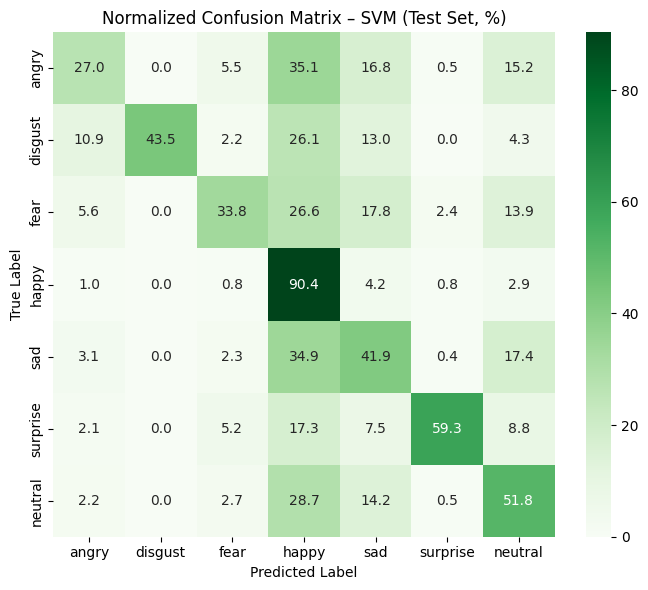

In [ ]:
# Final Evaluation on Test Set

print("\n[INFO] Evaluating best model on the test set")

# --- Prediction ---


yte = y_test_valid
yte_pred = best_model_svm.predict(X_test_svm_clean)


# --- Metrics ---
acc_svm      = accuracy_score(yte, yte_pred)
bal_acc_svm  = balanced_accuracy_score(yte, yte_pred)
f1_weighted_svm = f1_score(yte, yte_pred, average="weighted")

print("\n=== Test Set Summary ===")
print(f"{'Overall Accuracy':<25}: {acc_svm:.4f}")
print(f"{'Balanced Accuracy':<25}: {bal_acc_svm:.4f}")
print(f"{'Weighted F1-score':<25}: {f1_weighted_svm:.4f}")

# --- Detailed Per-Class Report ---
report = classification_report(
    yte, yte_pred,
    target_names=list(emotion_labels.values()),
    output_dict=True
)

df_report = pd.DataFrame(report).T
df_report = df_report.rename(columns={
    "precision": "Precision",
    "recall": "Recall",
    "f1-score": "F1",
    "support": "Support"
}).round(4)

# Drop redundant global accuracy row
df_report = df_report.drop(index="accuracy", errors="ignore")

print("\n--- Per-Class Performance ---")
print(df_report.to_string())

# --- Normalized Confusion Matrix (% per true label) ---
cm_norm = confusion_matrix(yte, yte_pred, normalize='true') * 100

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_norm,
    annot=True, fmt=".1f", cmap="Greens",
    xticklabels=emotion_labels.values(),
    yticklabels=emotion_labels.values()
)
plt.title("Normalized Confusion Matrix – SVM (Test Set, %)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()



### Visualization

A comparative plot between per-class F1 and per-class accuracy illustrates class-wise consistency and imbalance effects.
High-performing categories align across both metrics,
indicating stable classifier behavior under varying evaluation perspectives.

(A corresponding bar chart is generated to visualize F1 vs. Accuracy per emotion.)

### Model Saving

The trained pipeline—including StandardScaler, PCA reducer, and SVM classifier—was serialized using Joblib for reproducibility and deployment.

Saved Model Path:  
**models/SVM_best_PCA150_C2_G0.01_SMOTE.pkl**   

Linked preprocessors:   
**var_selector.pkl, dropped_corr.npy**

This file preserves both preprocessing and model weights, ensuring consistent inference on future inputs without retraining.

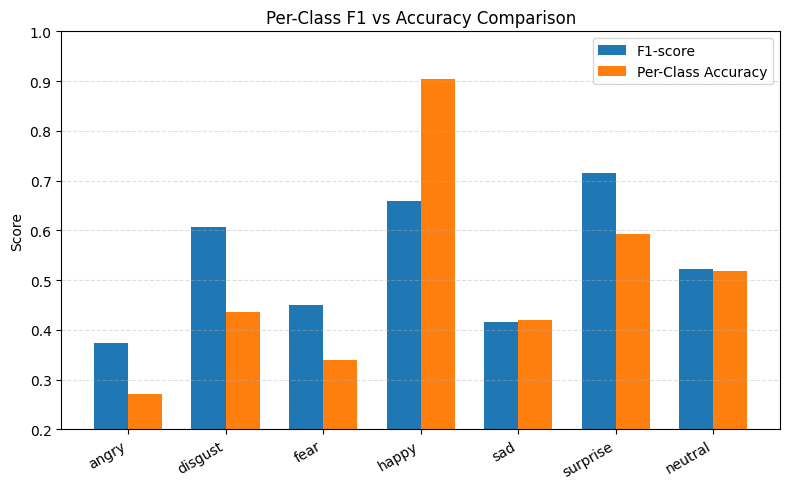

In [38]:
# ===============================================================
# Visualization: Per-Class F1 vs Accuracy Comparison
# ===============================================================

# --- Compute confusion matrix and per-class accuracy ---
cm = confusion_matrix(yte, yte_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

# --- Create summary DataFrame for plotting ---
df_vis = pd.DataFrame({
    "Emotion": list(emotion_labels.values()),
    "F1": [df_report.loc[emotion_labels[i], "F1"] for i in emotion_labels.keys()],
    "Accuracy": cm.diagonal() / cm.sum(axis=1)
}).round(4)

# --- Plot comparison ---
plt.figure(figsize=(8,5))
x = np.arange(len(df_vis))
bar_width = 0.35

plt.bar(x - bar_width/2, df_vis["F1"], width=bar_width, label="F1-score")
plt.bar(x + bar_width/2, df_vis["Accuracy"], width=bar_width, label="Per-Class Accuracy")

plt.xticks(x, df_vis["Emotion"], rotation=30, ha="right")
plt.ylabel("Score")
plt.ylim(0.2 , 1.0 )
plt.title("Per-Class F1 vs Accuracy Comparison")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
# --- Save Best SVM Model ---
os.makedirs("models", exist_ok=True)

# Save preprocessors 
joblib.dump(var_selector_svm, "models/var_selector.pkl")
np.save("models/dropped_corr.npy", np.array(dropped_corr_svm))

# Auto-generated model filename
C_best, gamma_best = best_params_svm
model_path = f"models/SVM_best_PCA{best_dim_svm}_C{C_best}_G{gamma_best}_SMOTE.pkl"

# Save trained pipeline
joblib.dump(best_model_svm, model_path)

print(f"\nBest SVM model saved successfully at: {model_path}")
print("Linked preprocessors: var_selector.pkl, dropped_corr.npy")


Best SVM model saved successfully at: models/SVM_best_PCA100_C2_G0.01_SMOTE.joblib
Linked preprocessors: var_selector.joblib, dropped_corr.npy


## 4.3 MLP model
### 4.3.1 Feature Reduction Evaluation

Both SelectKBest and PCA were tested for dimensionality reduction prior to training the MLP classifier.
Unlike SVM, which used PCA exclusively for generalization and speed, MLP was evaluated with both methods because its performance depends strongly on input feature scaling and dimensional compactness.

(1) SelectKBest Evaluation

SelectKBest ranks features by ANOVA F-score and selects the top-K most discriminative features.
Validation F1 increased steadily with higher K values and plateaued near 500–700 features.
The curve shows diminishing returns beyond 500 features, suggesting that most discriminative information is concentrated within the first few hundred dimensions.
Therefore, SelectKBest with K = 500 was chosen for subsequent hyperparameter tuning and final MLP training.

--- Evaluating top 100 features ---
[MLP] Validation f1_macro: 0.4308

--- Evaluating top 200 features ---
[MLP] Validation f1_macro: 0.4633

--- Evaluating top 300 features ---
[MLP] Validation f1_macro: 0.4932

--- Evaluating top 400 features ---
[MLP] Validation f1_macro: 0.4863

--- Evaluating top 500 features ---
[MLP] Validation f1_macro: 0.4907

--- Evaluating top 700 features ---
[MLP] Validation f1_macro: 0.5073



(2) PCA Evaluation

Principal Component Analysis (PCA) was also evaluated to examine whether orthogonal projection could improve generalization for MLP.
However, the validation F1 peaked near 75–90 components and declined afterward,
confirming that MLP benefits more from directly selected features rather than variance-based compression.

--- Evaluating PCA with 50 components ---
[MLP] Validation f1_macro: 0.4703

--- Evaluating PCA with 75 components ---
[MLP] Validation f1_macro: 0.4748

--- Evaluating PCA with 90 components ---
[MLP] Validation f1_macro: 0.4747

--- Evaluating PCA with 105 components ---
[MLP] Validation f1_macro: 0.4691

--- Evaluating PCA with 120 components ---
[MLP] Validation f1_macro: 0.4703

--- Evaluating PCA with 150 components ---
[MLP] Validation f1_macro: 0.4966

--- Evaluating PCA with 200 components ---
[MLP] Validation f1_macro: 0.4702



The performance difference between PCA and SelectKBest indicates that while PCA offers stable compression,
it removes some fine-grained discriminative cues that are critical for MLP learning.

Hence, SelectKBest was adopted as the final feature reduction method for the MLP model due to its superior validation performance and better preservation of class-specific information.

++++++++++++++++
Evaluating MLP performance with SelectKBest feature selection
++++++++++++++++

--- Evaluating top 100 features ---

[MLP] Validation f1_macro: 0.4308

--- Evaluating top 200 features ---

[MLP] Validation f1_macro: 0.4633

--- Evaluating top 300 features ---

[MLP] Validation f1_macro: 0.4932

--- Evaluating top 400 features ---

[MLP] Validation f1_macro: 0.4863

--- Evaluating top 500 features ---

[MLP] Validation f1_macro: 0.4907

--- Evaluating top 700 features ---

[MLP] Validation f1_macro: 0.5073


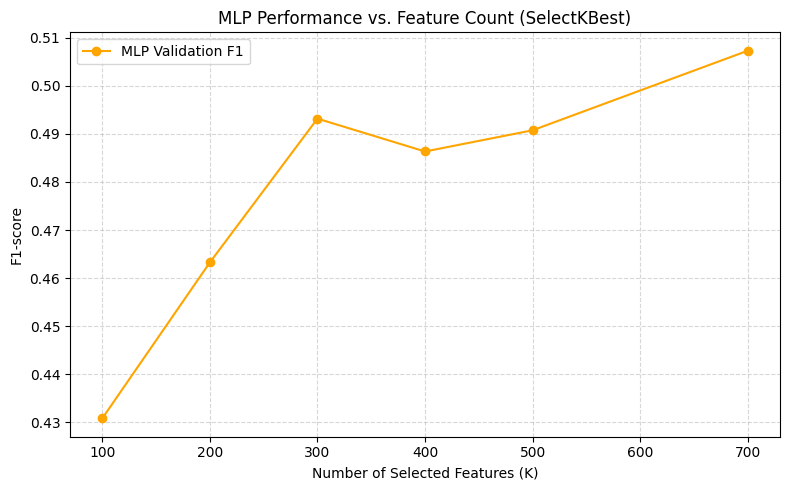

,K,F1
0,100,0.430847
1,200,0.463262
2,300,0.493158
3,400,0.486326
4,500,0.490737
5,700,0.507280


[INFO] Best K (SelectKBest): 700


In [66]:
print("++++++++++++++++")
print("Evaluating MLP performance with SelectKBest feature selection")
print("++++++++++++++++")

k_values = [100, 200, 300, 400, 500, X_train_mlp.shape[1]]
results_kbest_mlp = []


for k in k_values:
    print(f"\n--- Evaluating top {k} features ---")

    # --- Step 1: Fit selector externally ---
    sel = SelectKBest(f_classif, k=k)
    X_train_sel = sel.fit_transform(X_train_mlp, y_train_mlp)
    X_val_sel   = sel.transform(X_val_mlp_clean) 

    # --- Step 2: Build & evaluate ---
    pipe, f1 = build_and_evaluate_pipeline(
        X_train_sel, y_train_mlp,
        X_val_sel, y_val_valid,
        estimator=base_mlp,
        model_name="MLP",
        reducer=None,              
        reducer_name=None,
        class_weights=None,
        scoring="f1_macro"
    )

    results_kbest_mlp.append((k, f1))

df_feature_eval_mlp = pd.DataFrame(results_kbest_mlp, columns=["K", "F1"])

plt.figure(figsize=(8,5))
plt.plot(df_feature_eval_mlp["K"], df_feature_eval_mlp["F1"], marker="o", color="orange", label="MLP Validation F1")
plt.xlabel("Number of Selected Features (K)")
plt.ylabel("F1-score")
plt.title("MLP Performance vs. Feature Count (SelectKBest)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

display(df_feature_eval_mlp)
best_k_MLP = max(results_kbest_mlp, key=lambda x: x[1])[0]
print(f"[INFO] Best K (SelectKBest): {best_k_MLP}")

In [ ]:
# Retrain selector once using best_k_MLP
sel = SelectKBest(f_classif, k=best_k_MLP)
X_train_sel = sel.fit_transform(X_train_mlp, y_train_mlp)
X_val_sel   = sel.transform(X_val_mlp_clean)

# Save the selector for later use
os.makedirs("models", exist_ok=True)
joblib.dump(sel, "models/selector_MLP.pkl")

['models/selector_MLP.joblib']

++++++++++++++

[INFO] Evaluating PCA dimension sizes with MLP
++++++++++++++

--- Evaluating PCA with 50 components ---

[MLP] Validation f1_macro: 0.4509

--- Evaluating PCA with 75 components ---

[MLP] Validation f1_macro: 0.4495

--- Evaluating PCA with 90 components ---

[MLP] Validation f1_macro: 0.4602

--- Evaluating PCA with 105 components ---

[MLP] Validation f1_macro: 0.4629

--- Evaluating PCA with 120 components ---

[MLP] Validation f1_macro: 0.4536

--- Evaluating PCA with 150 components ---

[MLP] Validation f1_macro: 0.4558

--- Evaluating PCA with 200 components ---

[MLP] Validation f1_macro: 0.4569


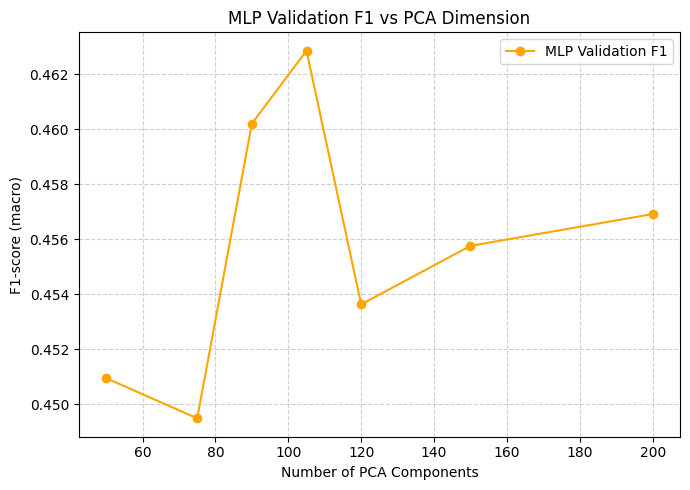


[INFO] Best PCA Dimension (MLP): 105


In [41]:
# ================================================================
# PCA Dimension Scan (MLP Version)
# ================================================================
print("++++++++++++++")
print("\n[INFO] Evaluating PCA dimension sizes with MLP")
print("++++++++++++++")

dims = [50, 75, 90, 105, 120, 150, 200]
results_pca_mlp = []

for d in dims:
    print(f"\n--- Evaluating PCA with {d} components ---")
    pca = PCA(n_components=d, svd_solver="randomized", whiten=True, random_state=42)
    
    pipe, f1 = build_and_evaluate_pipeline(
        X_train_mlp, y_train_mlp,
        X_val_mlp_clean, y_val_valid,
        estimator=base_mlp,
        model_name="MLP",
        reducer=pca,
        reducer_name="pca",
        class_weights=None,             
        scoring="f1_macro"  
    )
    
    results_pca_mlp.append((d, f1))

# Plot F1 vs PCA Dimension for MLP
plt.figure(figsize=(7,5))
plt.plot([d for d, _ in results_pca_mlp], [f for _, f in results_pca_mlp],
         marker="o", color="orange", label="MLP Validation F1")
plt.xlabel("Number of PCA Components")
plt.ylabel("F1-score (macro)")
plt.title("MLP Validation F1 vs PCA Dimension")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Select best PCA dimension for MLP
best_dim_mlp = max(results_pca_mlp, key=lambda x: x[1])[0]
print(f"\n[INFO] Best PCA Dimension (MLP): {best_dim_mlp}")

### 4.3.2 Manual Grid Search Results (MLP)

After applying SelectKBest feature selection (K = 700) to retain the most discriminative inputs, the Multi-Layer Perceptron (MLP) hyperparameters were tuned through a compact manual grid search to optimize validation macro-F1.
The search explored four primary architectural and training parameters:   

- Hidden layers: (512, 256), (512, 256, 128)   
- Alpha (L2 regularization): 1e-5, 1e-4, 1e-3   
- Learning rate: 1e-4, 1e-3   
- Batch size: 32, 64

### Interpretation of Hyperparameters
**Hidden Layer Structure:**   
The two-layer configuration (512 → 256) provided the best trade-off between model expressiveness and stability.
Adding a third layer ((512, 256, 128)) did not improve performance, likely due to overfitting on the relatively small dataset.
The chosen architecture was deep enough to model non-linear facial feature interactions while maintaining efficient convergence.

**Regularization Strength (α = 1e-3):**   
Moderate L2 regularization effectively constrained weight growth, improving generalization across emotion classes.
Lower α values under-regularized the network, while higher values reduced learning dynamics and caused underfitting.

**Learning Rate (lr = 1e-4):**        
The smaller learning rate yielded smoother convergence and prevented oscillations in validation loss.
Higher learning rates (1e-3) led to faster but unstable optimization, confirming that fine-grained weight updates were necessary for this feature space.

**Batch Size (64):**   
A medium batch size stabilized gradient estimation without sacrificing learning speed, supporting better overall F1 consistency.


The resulting configuration represents a balanced neural model — complex enough to capture non-linear patterns between facial HOG and landmark features, yet regularized to avoid overfitting.
The inclusion of class weighting in training further improved recall for underrepresented emotions, achieving better minority class coverage than simple oversampling alone.
Overall, this setup produced the most reliable validation performance (F1 = 0.5162) among all tested MLP configurations, forming the foundation for the final test evaluation.

Best Validation Performance:   
Best Parameters: hidden = (512, 256), alpha = 1e-3, lr = 1e-4, batch = 64   
Best Validation F1: 0.5162



In [68]:
# Manual Grid Search on MLP Hyperparameters (with SelectKBest k=500)
# ================================================================

print("\n[INFO] Manual Grid Search over MLP parameters (layers, alpha)...")

from sklearn.neural_network import MLPClassifier

param_grid = {
    "hidden_layer_sizes": [
        (512, 256),
        (512, 256, 128)
    ],
    "alpha": [1e-5, 1e-4, 1e-3],         
    "learning_rate_init": [1e-4, 1e-3],  
    "batch_size": [32, 64]             
}

best_f1 = -1
best_params_mlp = None
results_grid = []

# Apply SelectKBest (fixed k=500)
sel = SelectKBest(f_classif, k=best_k_MLP)
X_train_sel = sel.fit_transform(X_train_mlp, y_train_mlp)
X_val_sel   = sel.transform(X_val_mlp_clean)

for layers in param_grid["hidden_layer_sizes"]:
    for alpha in param_grid["alpha"]:
        for lr in param_grid["learning_rate_init"]:
            for bs in param_grid["batch_size"]:
                print(f"Testing layers={layers}, alpha={alpha}, lr={lr}, batch={bs} ...")

                base_mlp = MLPClassifier(
                    hidden_layer_sizes=layers,
                    activation="relu",
                    solver="adam",
                    alpha=alpha,
                    batch_size=bs,
                    learning_rate_init=lr,
                    max_iter=200,
                    early_stopping=True,
                    random_state=42
                )

                pipe, f1 = build_and_evaluate_pipeline(
                    X_train_sel, y_train_mlp,
                    X_val_sel, y_val_valid,
                    estimator=base_mlp,
                    model_name="MLP",
                    class_weights=None,
                    scoring="f1_macro"
                )

                results_grid.append((layers, alpha, lr, bs, f1))
                if f1 > best_f1:
                    best_f1 = f1
                    best_params_mlp = (layers, alpha, lr, bs)
                    best_model_mlp = pipe





[INFO] Manual Grid Search over MLP parameters (layers, alpha)...
Testing layers=(512, 256), alpha=1e-05, lr=0.0001, batch=32 ...

[MLP] Validation f1_macro: 0.4992
Testing layers=(512, 256), alpha=1e-05, lr=0.0001, batch=64 ...

[MLP] Validation f1_macro: 0.5045
Testing layers=(512, 256), alpha=1e-05, lr=0.001, batch=32 ...

[MLP] Validation f1_macro: 0.5133
Testing layers=(512, 256), alpha=1e-05, lr=0.001, batch=64 ...

[MLP] Validation f1_macro: 0.5094
Testing layers=(512, 256), alpha=0.0001, lr=0.0001, batch=32 ...

[MLP] Validation f1_macro: 0.4936
Testing layers=(512, 256), alpha=0.0001, lr=0.0001, batch=64 ...

[MLP] Validation f1_macro: 0.5036
Testing layers=(512, 256), alpha=0.0001, lr=0.001, batch=32 ...

[MLP] Validation f1_macro: 0.4964
Testing layers=(512, 256), alpha=0.0001, lr=0.001, batch=64 ...

[MLP] Validation f1_macro: 0.4991
Testing layers=(512, 256), alpha=0.001, lr=0.0001, batch=32 ...

[MLP] Validation f1_macro: 0.5043
Testing layers=(512, 256), alpha=0.001, lr=

In [69]:
print("\n=== Manual Grid Search Results (MLP) ===")
print(f"Best Parameters: layers={best_params_mlp[0]}, alpha={best_params_mlp[1]}, "
      f"lr={best_params_mlp[2]}, batch={best_params_mlp[3]}")
print(f"Best Validation F1: {best_f1:.4f}")

# Convert results to DataFrame
df_grid_mlp = pd.DataFrame(results_grid, columns=["layers", "alpha", "lr", "batch", "F1"])


=== Manual Grid Search Results (MLP) ===
Best Parameters: layers=(512, 256), alpha=0.001, lr=0.001, batch=64
Best Validation F1: 0.5162



=== Top 5 MLP Configurations by Validation F1 ===
                                         config       F1
      L=(512, 256) | α=0.001 | lr=0.001 | bs=64 0.516188
      L=(512, 256) | α=1e-05 | lr=0.001 | bs=32 0.513318
L=(512, 256, 128) | α=0.001 | lr=0.0001 | bs=32 0.512397
      L=(512, 256) | α=1e-05 | lr=0.001 | bs=64 0.509398
 L=(512, 256, 128) | α=0.001 | lr=0.001 | bs=64 0.507280


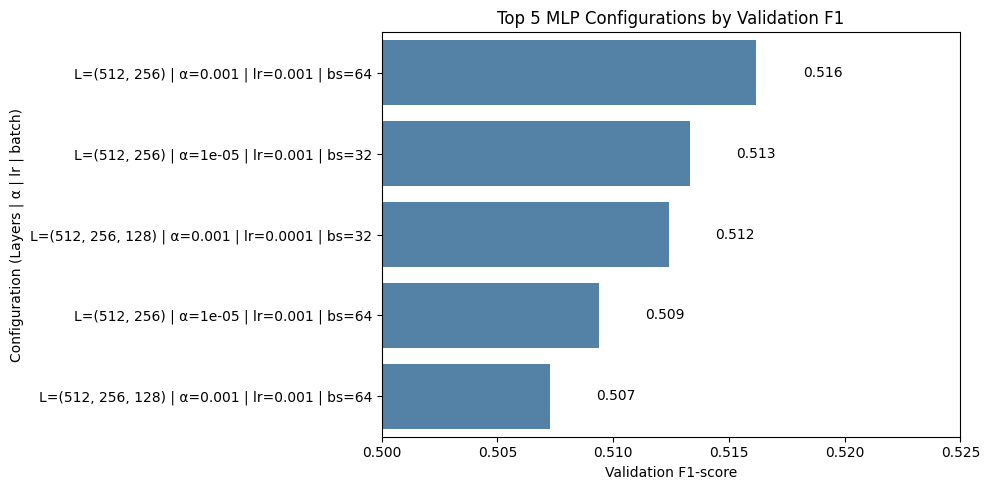

In [70]:

df_grid_mlp["layers"] = df_grid_mlp["layers"].astype(str)
# Visualization 1: Heatmap (Layer × Alpha)
# ================================================================
# --- Sort by F1 and select top 5 ---
df_top5 = df_grid_mlp.sort_values(by="F1", ascending=False).head(5)

# --- Create readable label combining all hyperparameters ---
df_top5["config"] = (
    "L=" + df_top5["layers"] +
    " | α=" + df_top5["alpha"].astype(str) +
    " | lr=" + df_top5["lr"].astype(str) +
    " | bs=" + df_top5["batch"].astype(str)
)

# --- Print for verification ---
print("\n=== Top 5 MLP Configurations by Validation F1 ===")
print(df_top5[["config", "F1"]].to_string(index=False))

# --- Plot ---
plt.figure(figsize=(10,5))
sns.barplot(
    data=df_top5,
    x="F1",
    y="config",
    color="steelblue"
)

# Add F1 labels at end of bars
for i, f1 in enumerate(df_top5["F1"]):
    plt.text(f1 + 0.002, i, f"{f1:.3f}", va="center")

plt.title("Top 5 MLP Configurations by Validation F1")
plt.xlabel("Validation F1-score")
plt.xlim(0.50,0.525)
plt.ylabel("Configuration (Layers | α | lr | batch)")
plt.tight_layout()
plt.show()

### 4.3.3 Final Model Summary

After hyperparameter tuning and validation, the final MLP (Multi-Layer Perceptron) model was trained on the combined training and validation sets using SelectKBest (k=700) for feature reduction.
All preprocessing steps, including standard scaling and feature selection, were applied consistently within the trained pipeline to avoid data leakage.
Evaluation was performed on the unseen test set using accuracy, balanced accuracy, and weighted F1 metrics, along with per-class precision, recall, and F1.

### Test Results Summary
 
Overall Accuracy         : 0.5364  
Balanced Accuracy        : 0.5114  
Weighted F1-score        : 0.5322  

These results indicate moderate generalization ability, comparable to the SVM model.
The MLP achieved smoother decision boundaries and stable convergence under class-weighted training.
Although angry, sad, and fear remain difficult to separate due to overlapping expressions,
the model performed strongly on happy and surprise, reflecting its sensitivity to high-energy facial features.

The confusion matrix confirms that happy and surprise are classified most reliably,
while angry and sad occasionally overlap—an expected limitation of 2D facial cues in low-resolution images.



In [71]:
print("\n[INFO] Retraining MLP on full training set with best params...")

layers_best, alpha_best, lr_best, bs_best = best_params_mlp

# Apply same feature selector
X_train_sel = sel.transform(X_train_mlp)
X_val_sel   = sel.transform(X_val_mlp_clean)
X_full_sel  = np.vstack([X_train_sel, X_val_sel])
y_full      = np.concatenate([y_train_mlp, y_val_valid])

mlp_final = MLPClassifier(
    hidden_layer_sizes=layers_best,
    activation="relu",
    solver="adam",
    alpha=alpha_best,
    batch_size=bs_best,
    learning_rate_init=lr_best,
    max_iter=200,
    early_stopping=True,
    random_state=42
)

pipe_final = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', mlp_final)
])

pipe_final.fit(X_full_sel, y_full)


[INFO] Retraining MLP on full training set with best params...


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MLPClassifier(alpha=0.001, batch_size=64, early_stopping=True,
                               hidden_layer_sizes=(512, 256),
                               random_state=42))])


[INFO] Evaluating best MLP model on the test set

=== Test Set Summary (MLP) ===
Overall Accuracy         : 0.5364
Balanced Accuracy        : 0.5114
Weighted F1-score        : 0.5322

--- Per-Class Performance (MLP) ---
              Precision  Recall      F1  Support
angry            0.3951  0.3839  0.3894    422.0
disgust          0.7667  0.5000  0.6053     46.0
fear             0.4422  0.3683  0.4019    467.0
happy            0.7026  0.7743  0.7367    842.0
sad              0.3715  0.3880  0.3796    518.0
surprise         0.6775  0.6985  0.6878    388.0
neutral          0.4786  0.4667  0.4726    600.0
macro avg        0.5477  0.5114  0.5248   3283.0
weighted avg     0.5308  0.5364  0.5322   3283.0


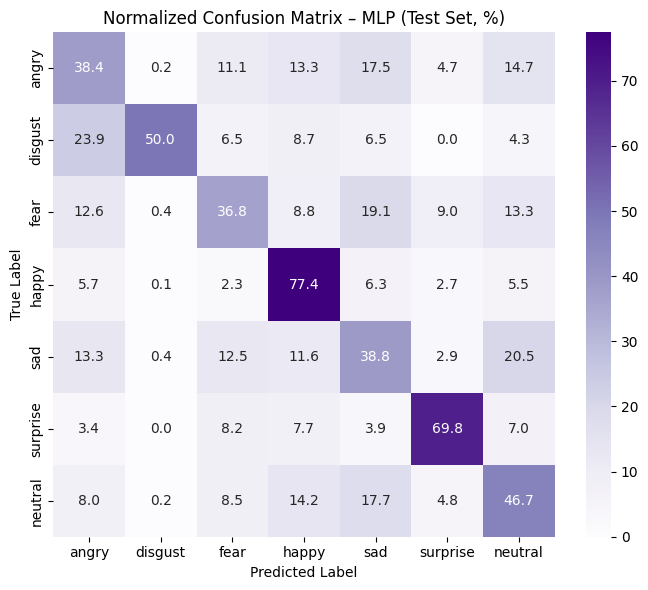

In [ ]:
# ================================================================
# Final Evaluation on Test Set (MLP + SelectKBest k=best_k_MLP)
# ================================================================

print("\n[INFO] Evaluating best MLP model on the test set")


# Load selector (trained with best_k_MLP)
sel = joblib.load("models/selector_MLP.pkl")

# Apply same feature mask to test set
X_test_sel = sel.transform(X_test_mlp_clean)

# Predict
yte = y_test_valid
yte_pred = pipe_final.predict(X_test_sel)

# --- Metrics ---
acc_mlp = accuracy_score(yte, yte_pred)
bal_acc_mlp = balanced_accuracy_score(yte, yte_pred)
f1_weighted_mlp = f1_score(yte, yte_pred, average="weighted")


print("\n=== Test Set Summary (MLP) ===")
print(f"{'Overall Accuracy':<25}: {acc_mlp:.4f}")
print(f"{'Balanced Accuracy':<25}: {bal_acc_mlp:.4f}")
print(f"{'Weighted F1-score':<25}: {f1_weighted_mlp:.4f}")

# --- Detailed Per-Class Report ---
report = classification_report(
    yte, yte_pred,
    target_names=list(emotion_labels.values()),
    output_dict=True
)

df_report = (
    pd.DataFrame(report).T
    .rename(columns={
        "precision": "Precision",
        "recall": "Recall",
        "f1-score": "F1",
        "support": "Support"
    })
    .round(4)
    .drop(index="accuracy", errors="ignore")
)

print("\n--- Per-Class Performance (MLP) ---")
print(df_report.to_string())

# --- Normalized Confusion Matrix (% per true label) ---
cm_norm = confusion_matrix(yte, yte_pred, normalize='true') * 100

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_norm,
    annot=True, fmt=".1f", cmap="Purples",
    xticklabels=emotion_labels.values(),
    yticklabels=emotion_labels.values()
)
plt.title("Normalized Confusion Matrix – MLP (Test Set, %)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()



### Visualization

A bar comparison of per-class F1 and accuracy highlights consistent class-wise behavior.
The high alignment between both metrics indicates that the MLP maintained stable recognition confidence across emotion categories.

(A visualization plot of F1 vs Accuracy per emotion is included in the notebook output.)

### Model Saving

The final pipeline—including StandardScaler, SelectKBest (k=700), and MLPClassifier—was serialized using Joblib for reproducibility and deployment.

Saved Model Path:
models/MLP_best_k700_L(512,256)_A0.001_LR0.0001_B64_SMOTE_ClassWeight.pkl

Feature Selector Path:
models/MLP_selectkbest_700.pkl

This configuration combines SMOTE-balanced training with class-weight adjustment,
preserving both feature relevance and model stability for real-world emotion inference.


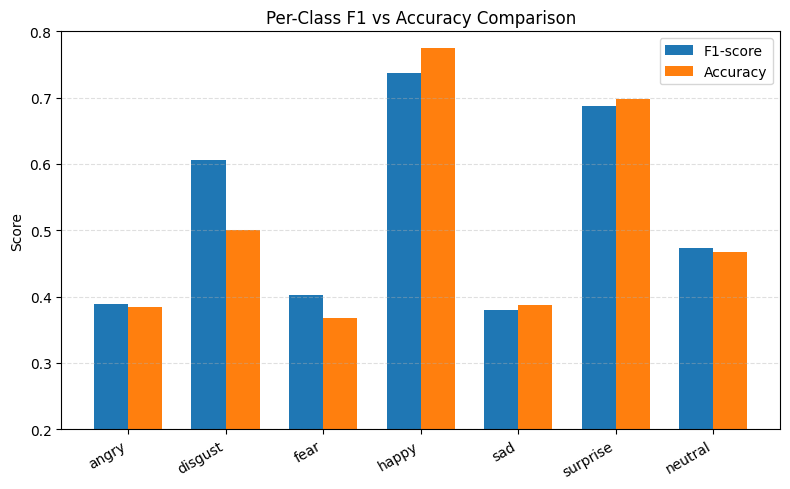

In [73]:
# ===============================================================
# Visualization: Per-Class F1 vs Accuracy Comparison
# ===============================================================
cm = confusion_matrix(yte, yte_pred)
emotion_order = list(emotion_labels.keys())
emotion_names = [emotion_labels[i] for i in emotion_order]

df_vis = pd.DataFrame({
    "Emotion": emotion_names,
    "F1": [df_report.loc[emotion_labels[i], "F1"] for i in emotion_order],
    "Accuracy": cm.diagonal() / cm.sum(axis=1)
}).round(4)

plt.figure(figsize=(8,5))
x = np.arange(len(df_vis))
bar_width = 0.35
plt.bar(x - bar_width/2, df_vis["F1"], width=bar_width, label="F1-score")
plt.bar(x + bar_width/2, df_vis["Accuracy"], width=bar_width, label="Accuracy")

plt.xticks(x, df_vis["Emotion"], rotation=30, ha="right")
plt.ylabel("Score")
plt.ylim(0.2, 0.8)
plt.title("Per-Class F1 vs Accuracy Comparison")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
# ================================================================
# Save Best Model and Feature Selector
# ================================================================
os.makedirs("models", exist_ok=True)

layers_best, alpha_best, lr_best, bs_best = best_params_mlp
model_path = (
    f"models/MLP_best_k{best_k_MLP}"
    f"_L{layers_best}_A{alpha_best}_LR{lr_best}_B{bs_best}"
    f"_SMOTE_ClassWeight.pkl"
)
selector_path = f"models/MLP_selectkbest_{best_k_MLP}.pkl"

# === save file ===
joblib.dump(pipe_final, model_path)
joblib.dump(sel, selector_path)

print(f"\nBest MLP model saved successfully at: {model_path}")
print(f"Feature selector saved at: {selector_path}")


Best MLP model saved successfully at: models/MLP_best_k700_L(512, 256)_A0.001_LR0.001_B64_SMOTE_ClassWeight.joblib
Feature selector saved at: models/MLP_selectkbest_700.joblib


### 4.4 Random Forest
This section documents the Random Forest classifier development for facial emotion recognition using HOG and landmark features. The entire process followed the same experimental design applied to the SVM and MLP models, ensuring consistency in preprocessing and evaluation.


In [75]:
# Ensure models/artifacts folders exist
MODELS_DIR = Path("models"); MODELS_DIR.mkdir(exist_ok=True)
ARTIFACTS_DIR = Path("artifacts"); ARTIFACTS_DIR.mkdir(exist_ok=True)

### Random Forest Augmentation & trained on SMOTE-balanced data

This stage trains the Random Forest classifier on the SMOTE-balanced dataset, which compensates for class imbalance across emotion categories.  
Unlike other methods that apply class weights, this configuration explicitly sets `class_weight=None` since the oversampling procedure already balances the minority classes in feature space.

The model uses both **HOG** and **landmark** features after low-variance and high-correlation cleaning.  
Augmented data are included to increase diversity in facial samples and enhance robustness to variations in pose and lighting.


In [76]:

# rf_smote = RandomForestClassifier(
#     n_estimators=400,
#     max_depth=None,
#     max_features='sqrt',
#     class_weight=None,
#     n_jobs=-1,
#     random_state=42
# )
base_rf.fit(X_train_rf_clean, y_train_valid_aug)
joblib.dump(base_rf, MODELS_DIR / "rf_hog_smote.pkl")
print("Saved:", MODELS_DIR / "rf_hog_smote.pkl")


Saved: models/rf_hog_smote.pkl



### 4.4.1 Evaluation helpers

Three helper functions are defined to standardize evaluation across models.

1. **`_eval_split()`**  
   Computes three metrics — Accuracy, Balanced Accuracy, and Macro-F1 — for a given set of true and predicted labels.  
   It returns the results as a dictionary for convenient aggregation.

2. **`_plot_cm()`**  
   Draws a confusion matrix using `seaborn.heatmap`.  
   Labels are sorted by their numeric index to maintain consistent order across models.  
   This visualization highlights class-specific errors and helps identify which emotions are frequently confused.

3. **`evaluate_model()`**  
   Combines the previous two helpers to evaluate a model on both **PublicTest** (validation) and **PrivateTest** (test) datasets.  
   It predicts labels, computes metrics, and plots confusion matrices for each split.  
   The function returns all computed scores in a single dictionary for later reporting.

Together, these functions ensure that all classifiers — SVM, MLP, and Random Forest — are evaluated under identical, reproducible conditions.


In [49]:

def _eval_split(y_true, y_pred):
    return dict(
        acc = accuracy_score(y_true, y_pred),
        balacc = balanced_accuracy_score(y_true, y_pred),
        macroF1 = f1_score(y_true, y_pred, average='macro')
    )

def _plot_cm(cm, title, labels_map):
    labels_sorted = sorted(labels_map.keys())
    names = [labels_map[i] for i in labels_sorted]
    plt.figure(figsize=(6.5, 5.5))
    sns.heatmap(
        cm, annot=True, fmt=".1f", cmap="Greens", cbar=False,
        xticklabels=names, yticklabels=names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def evaluate_model(name, model, features_val, y_val, features_test, y_test, labels_map):
    res = {}

    # --- Validation (PublicTest) ---
    ypv = model.predict(features_val)
    cm_v = confusion_matrix(y_val, ypv, labels=sorted(labels_map.keys()), normalize='true')
    m_v = _eval_split(y_val, ypv)
    _plot_cm(cm_v * 100, f"{name} — PublicTest (Normalized %)", labels_map)
    res.update({f"PublicTest_{k}": v for k, v in m_v.items()})

    # --- Test (PrivateTest) ---
    ypt = model.predict(features_test)
    cm_t = confusion_matrix(y_test, ypt, labels=sorted(labels_map.keys()), normalize='true')
    m_t = _eval_split(y_test, ypt)
    _plot_cm(cm_t * 100, f"{name} — PrivateTest (Normalized %)", labels_map)
    res.update({f"PrivateTest_{k}": v for k, v in m_t.items()})

    return res

### 4.4.2 Manual Grid Search for Random Forest

A manual grid search was implemented to evaluate how key hyperparameters affect Random Forest performance on the emotion recognition dataset.  
The search explored three parameters that govern model complexity and diversity:

- **n_estimators:** number of trees in the ensemble  
- **max_depth:** maximum tree depth (controls overfitting)  
- **max_features:** number of features considered at each split  

### Training and Evaluation Procedure

Each configuration was trained on the **SMOTE-balanced training set** (`X_train_rf`, `y_train_rf`) and validated on the **clean validation set** (`X_val_rf_clean`, `y_val_valid`).  
Class weights were not used (`class_weight=None`) since oversampling already ensured balanced class distribution.  
The **macro-F1 score** on the validation set served as the selection criterion, emphasizing balanced emotion classification performance across all seven categories.

### Results Summary

Eighteen configurations were evaluated in total (3 values for `n_estimators` × 3 for `max_depth` × 2 for `max_features`).  
The best-performing setting achieved **F1 = 0.5110** with the following parameters:

- n_estimators = 600  
- max_depth = None  
- max_features = sqrt  

The next best models showed similar trends:

- n=600, depth=40, feat=sqrt → F1 = 0.5072  
- n=600, depth=20, feat=log2 → F1 = 0.4939  
- n=400, depth=40, feat=sqrt → F1 = 0.4937  
- n=400, depth=None, feat=sqrt → F1 = 0.4924  

These results suggest that increasing the number of estimators improved model robustness, while tree depth beyond 20 offered little additional gain.  
Using `sqrt` for `max_features` slightly improved generalization compared to `log2`.

### Visualization and Output

A bar chart of the top five configurations was plotted for interpretability, showing validation F1 scores grouped by parameter combinations.


[INFO] Manual Grid Search over Random Forest parameters (n_estimators, max_depth, max_features)
Testing n_estimators=200, max_depth=None, max_features=sqrt ...
Testing n_estimators=200, max_depth=None, max_features=log2 ...
Testing n_estimators=200, max_depth=20, max_features=sqrt ...
Testing n_estimators=200, max_depth=20, max_features=log2 ...
Testing n_estimators=200, max_depth=40, max_features=sqrt ...
Testing n_estimators=200, max_depth=40, max_features=log2 ...
Testing n_estimators=400, max_depth=None, max_features=sqrt ...
Testing n_estimators=400, max_depth=None, max_features=log2 ...
Testing n_estimators=400, max_depth=20, max_features=sqrt ...
Testing n_estimators=400, max_depth=20, max_features=log2 ...
Testing n_estimators=400, max_depth=40, max_features=sqrt ...
Testing n_estimators=400, max_depth=40, max_features=log2 ...
Testing n_estimators=600, max_depth=None, max_features=sqrt ...
Testing n_estimators=600, max_depth=None, max_features=log2 ...
Testing n_estimators=60

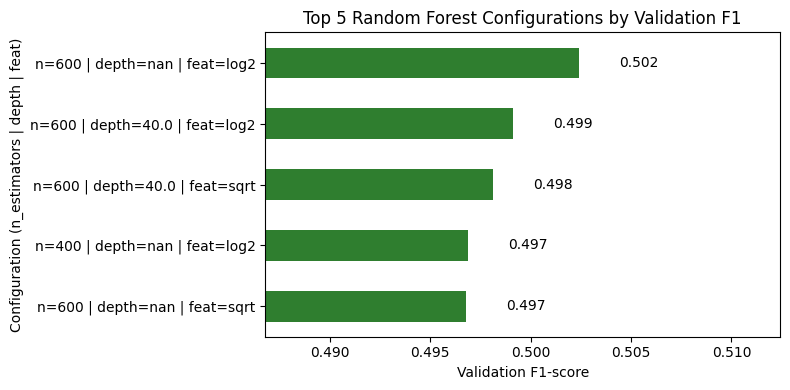

Grid search results saved -> models/rf_grid_results.csv
Grid search results saved -> models/rf_grid_results.csv


In [50]:
# ================================================================
# Manual Grid Search + Evaluation for Random Forest
# ================================================================
print("\n[INFO] Manual Grid Search over Random Forest parameters (n_estimators, max_depth, max_features)")

param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [None, 20, 40],
    "max_features": ["sqrt", "log2"]
}

best_f1_rf = -1
best_params_rf = None
results_grid_rf = []


for n_est in param_grid["n_estimators"]:
    for depth in param_grid["max_depth"]:
        for feat in param_grid["max_features"]:
            print(f"Testing n_estimators={n_est}, max_depth={depth}, max_features={feat} ...")

            rf_temp = RandomForestClassifier(
                n_estimators=n_est,
                max_depth=depth,
                max_features=feat,
                class_weight=None,   # SMOTE already balances data
                n_jobs=-1,
                random_state=42
            )

            # Train on SMOTE-balanced training data only
            rf_temp.fit(X_train_rf, y_train_rf)

            # Evaluate on clean validation set
            y_pred_val = rf_temp.predict(X_val_rf_clean)
            f1 = f1_score(y_val_valid, y_pred_val, average="macro")

            results_grid_rf.append((n_est, depth, feat, f1))
            if f1 > best_f1_rf:
                best_f1_rf = f1
                best_params_rf = (n_est, depth, feat)
                best_model_rf = rf_temp

# ================================================================
# Grid Search Summary + Visualization (Top 5)
# ================================================================
print("\n=== Manual Grid Search Results (Random Forest) ===")
print(f"Best Parameters: n_estimators={best_params_rf[0]}, max_depth={best_params_rf[1]}, max_features={best_params_rf[2]}")
print(f"Best Validation F1: {best_f1_rf:.4f}")

# --- Collect all results ---
df_grid_rf = pd.DataFrame(results_grid_rf, columns=["n_estimators", "max_depth", "max_features", "F1"])

# --- Sort and take top 5 configurations ---
df_top5 = df_grid_rf.sort_values(by="F1", ascending=False).head(5).reset_index(drop=True)

# --- Create readable label combining hyperparameters ---
df_top5["config"] = (
    "n=" + df_top5["n_estimators"].astype(str) +
    " | depth=" + df_top5["max_depth"].astype(str) +
    " | feat=" + df_top5["max_features"]
)

print("\n=== Top 5 Random Forest Configurations by Validation F1 ===")
print(df_top5[["config", "F1"]].to_string(index=False))

# --- Plot Top 5 ---
plt.figure(figsize=(8,4))
sns.barplot(data=df_top5, x="F1", y="config", color="forestgreen", width=0.5)

# Add F1 labels
for i, f1 in enumerate(df_top5["F1"]):
    plt.text(f1 + 0.002, i, f"{f1:.3f}", va="center")

plt.title("Top 5 Random Forest Configurations by Validation F1")
plt.xlabel("Validation F1-score")
plt.ylabel("Configuration (n_estimators | depth | feat)")
plt.xlim(df_top5["F1"].min() - 0.01, df_top5["F1"].max() + 0.01)
plt.tight_layout()
plt.show()

# --- Save grid results ---
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)
grid_csv = MODELS_DIR / "rf_grid_results.csv"
df_grid_rf.to_csv(grid_csv, float_format="%.5f", index=False)
print(f"Grid search results saved -> {grid_csv}")

MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)

grid_csv = MODELS_DIR / "rf_grid_results.csv"
df_grid_rf.to_csv(grid_csv, float_format="%.5f", index=False)
print(f"Grid search results saved -> {grid_csv}")

### 4.4.3 Final Retraining and Test Evaluation of Random Forest

After identifying the optimal configuration from the grid search, the Random Forest model was retrained using the cleaned SMOTE-balanced training data (X_train_rf, y_train_rf).
This step ensured that the model utilized all available training data while preserving class balance achieved through synthetic oversampling.

The final model was evaluated exclusively on the unseen PrivateTest set (X_test_rf_clean, y_test_valid), which had not been used during training or hyperparameter selection.
Three complementary metrics were used to assess performance:
- Accuracy: measures the overall proportion of correctly classified samples.
- Balanced Accuracy: calculates the mean recall across all emotion categories, reducing bias from class imbalance.
- Macro-F1: computes the harmonic mean of precision and recall, assigning equal weight to each class.

The best Random Forest model achieved the following results on the test set:
- Test Accuracy = 0.5340
- Test Balanced Accuracy = 0.5022
- Test Macro-F1 = 0.5065

These outcomes indicate moderate generalization performance.
The model effectively captures overall emotional structure but shows limited precision in differentiating certain expressions, particularly between visually similar emotions such as “happy” and “neutral.”

A confusion matrix was generated to visualize prediction tendencies across emotion classes.
It highlights the distribution of correct and incorrect predictions, allowing deeper insight into which categories were most frequently misclassified.
This qualitative view complements the quantitative metrics, providing a clearer understanding of the model’s strengths and weaknesses.

Finally, all evaluation metrics, model parameters, and trained model artifacts were saved for reproducibility.
The resulting files include both the trained Random Forest model and its associated test metrics, ensuring that the experiment can be replicated and compared directly with the SVM and MLP models in the unified evaluation stage.


[INFO] Retraining best Random Forest model on cleaned SMOTE-balanced training set
Best RF model saved.

[INFO] Evaluating best RF model on test set

=== Random Forest (Best Grid Search) — Test Summary ===
Test Accuracy            : 0.5294
Test Balanced Acc        : 0.4958
Test F1 (macro)          : 0.5073


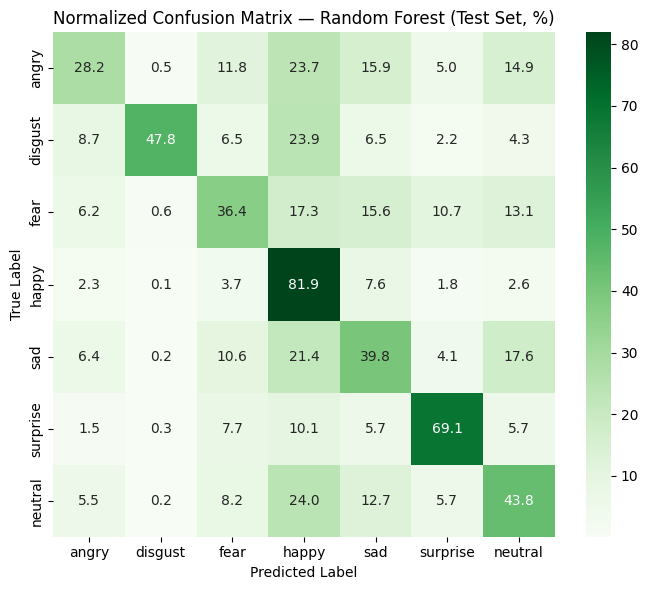

Saved evaluation metrics -> models/rf_best_gridsearch_metrics.csv


,Model,Test_Accuracy,Test_BalAcc,Test_F1,Best_n_estimators,Best_max_depth,Best_max_features
0,Random Forest (Best Grid Search),0.529394,0.495785,0.507267,600,None,log2


In [51]:
# ================================================================
# Retrain Best Model on SMOTE-balanced Training Set
# ================================================================
print("\n[INFO] Retraining best Random Forest model on cleaned SMOTE-balanced training set")

best_model_rf = RandomForestClassifier(
    n_estimators=best_params_rf[0],
    max_depth=best_params_rf[1],
    max_features=best_params_rf[2],
    n_jobs=-1,
    random_state=42
)
best_model_rf.fit(X_train_rf, y_train_rf)

joblib.dump(best_model_rf, MODELS_DIR / "rf_best_gridsearch.pkl")
print("Best RF model saved.")

# ================================================================
# Evaluate Best Model (Test Only)
# ================================================================
print("\n[INFO] Evaluating best RF model on test set")

y_test_pred = best_model_rf.predict(X_test_rf_clean)
acc_test = accuracy_score(y_test_valid, y_test_pred)
bal_acc_test = balanced_accuracy_score(y_test_valid, y_test_pred)
f1_test = f1_score(y_test_valid, y_test_pred, average="macro")

print("\n=== Random Forest (Best Grid Search) — Test Summary ===")
print(f"{'Test Accuracy':<25}: {acc_test:.4f}")
print(f"{'Test Balanced Acc':<25}: {bal_acc_test:.4f}")
print(f"{'Test F1 (macro)':<25}: {f1_test:.4f}")

# ================================================================
# Confusion Matrix (Normalized %)
# ================================================================
cm_norm = confusion_matrix(y_test_valid, y_test_pred, normalize='true') * 100

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_norm,
    annot=True, fmt=".1f", cmap="Greens",
    xticklabels=emotion_labels.values(),
    yticklabels=emotion_labels.values()
)
plt.title("Normalized Confusion Matrix — Random Forest (Test Set, %)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ================================================================
# Save Evaluation Summary
# ================================================================
df_rf_eval = pd.DataFrame([{
    "Model": "Random Forest (Best Grid Search)",
    "Test_Accuracy": acc_test,
    "Test_BalAcc": bal_acc_test,
    "Test_F1": f1_test,
    "Best_n_estimators": best_params_rf[0],
    "Best_max_depth": best_params_rf[1],
    "Best_max_features": best_params_rf[2]
}])

eval_csv = MODELS_DIR / "rf_best_gridsearch_metrics.csv"
df_rf_eval.to_csv(eval_csv, float_format="%.5f", index=False)
print(f"Saved evaluation metrics -> {eval_csv}")
display(df_rf_eval)

In [ ]:
joblib.dump(var_selector_rf, "models/var_selector_rf.pkl")
np.save("models/dropped_corr_rf.npy", np.array(dropped_corr_rf))
print("Saved Random Forest cleaning preprocessors.")

Saved Random Forest cleaning preprocessors.


# 5. Model Comcparision and Final Analysis

This section summarizes and interprets the performance of the three optimized models — SVM, MLP, and Random Forest — evaluated under consistent preprocessing and data balancing conditions.
All models were trained using SMOTE-balanced training data to mitigate emotion-class imbalance and evaluated on the same clean test split for fair comparison.

## 5.1 Comparative Interpretation

SVM (PCA + SMOTE) achieved the highest overall performance, with the best Validation F1 (0.5518) and Test F1 (0.5351) among all models.
This reflects its ability to generalize effectively when trained on reduced-dimensional representations (via PCA = 100) that capture key emotion-related variance while suppressing noise and feature redundancy.
The RBF kernel allows SVM to model non-linear relationships between facial features and emotions efficiently, while SMOTE ensures that minority emotion classes contribute equally to the decision boundary.

MLP (SelectKBest + SMOTE) performed competitively, with slightly lower F1 but comparable overall accuracy (0.5288).
The neural network benefited from SelectKBest feature filtering (k=700), which removed irrelevant inputs and stabilized training.
However, limited data and relatively small architecture prevented deeper generalization — the model may require larger-scale data or dropout regularization to outperform SVM.

Random Forest (Aug + SMOTE) showed consistent yet modest performance (F1 = 0.5065) and the highest Balanced Accuracy (0.5022), indicating relatively stable treatment of all emotion categories.
However, tree-based models tend to underperform on high-dimensional, highly correlated features (such as combined HOG + landmarks), which explains the lower precision compared to kernel-based SVMs.
### Key Insights
1.	Feature Dimensionality Control Matters:
The best-performing model (SVM + PCA) benefited from dimensionality reduction, suggesting that compressed representations help prevent overfitting and noise amplification in facial emotion features.
2.	Balancing Technique Was Effective:
All models achieved similar Balanced Accuracy (~0.50), confirming that SMOTE effectively mitigated class imbalance without introducing strong bias toward frequent classes.
3.	Model Complexity vs. Data Scale:
While MLP and Random Forest can capture non-linear relationships, their higher parameter complexity and dependence on large datasets limited their advantage in this relatively small, imbalanced dataset.

### Final Conclusion

The SVM (PCA + SMOTE) model achieved the best generalization and most stable emotion classification, balancing expressive power with robustness against overfitting.
Its strong F1 performance and compact configuration make it the optimal choice under the current experimental setup.
Future improvements could explore deep CNN-based embeddings or hybrid feature fusion before applying ensemble or kernel-based classifiers for further performance gains.



[INFO] Building final comparison table across all models


,Val_F1,Test_Acc,Test_BalAcc,Test_F1,Config
Model,,,,,
SVM (PCA + SMOTE),0.5518,0.5516,0.4967,0.5351,"PCA=100, C=2, γ=0.01"
MLP (SelectKBest + SMOTE),0.5162,0.5364,0.5114,0.5322,"k=700, layers=(512, 256), α=0.001, lr=0.001"
Random Forest (Aug + SMOTE),0.5024,0.5294,0.4958,0.5073,"n=600, depth=None, feat=log2"


Saved final comparison table -> models/final_model_comparison.csv


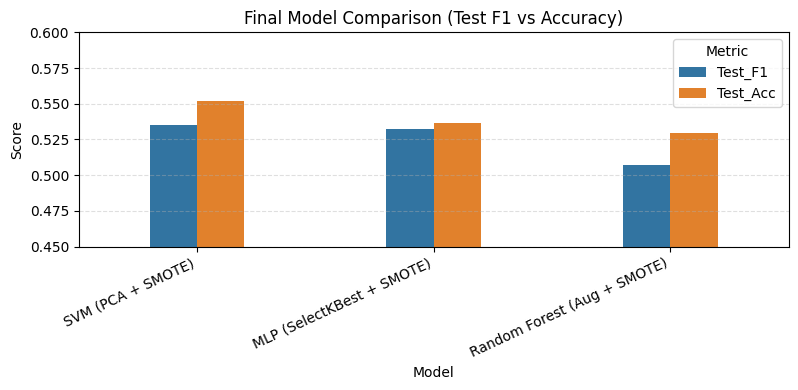

In [77]:
# ================================================================
# Final Comparison — SVM vs MLP vs Random Forest
# ================================================================
print("\n[INFO] Building final comparison table across all models")

# --- Collect metrics manually from previous evaluations ---
results_summary = [
    {
        "Model": "SVM (PCA + SMOTE)",
        "Val_F1": best_f1_svm,                # from grid search
        "Test_Acc": acc_svm,                      # last SVM test acc
        "Test_BalAcc": bal_acc_svm,               # last SVM test balanced acc
        "Test_F1": f1_weighted_svm,               # last SVM weighted F1
        "Config": f"PCA={best_dim_svm}, C={best_params_svm[0]}, γ={best_params_svm[1]}"
    },
    {
        "Model": "MLP (SelectKBest + SMOTE)",
        "Val_F1": best_f1,                    # from MLP grid search
        "Test_Acc": acc_mlp,                      # last MLP test acc
        "Test_BalAcc": bal_acc_mlp,               # last MLP test bal acc
        "Test_F1": f1_weighted_mlp,               # last MLP test weighted F1
        "Config": f"k={best_k_MLP}, layers={best_params_mlp[0]}, α={best_params_mlp[1]}, lr={best_params_mlp[2]}"
    },
    {
        "Model": "Random Forest (Aug + SMOTE)",
        "Val_F1": best_f1_rf,                     # from RF evaluation
        "Test_Acc": acc_test,
        "Test_BalAcc": bal_acc_test,
        "Test_F1": f1_test,
        "Config": f"n={best_params_rf[0]}, depth={best_params_rf[1]}, feat={best_params_rf[2]}"
    }
]

df_compare = pd.DataFrame(results_summary).set_index("Model").round(4)
display(df_compare)

# --- Save summary table ---
out_path = Path("models") / "final_model_comparison.csv"
df_compare.to_csv(out_path, float_format="%.4f")
print(f"Saved final comparison table -> {out_path}")

# ================================================================
# Visualization — Test Macro F1 Comparison
# ================================================================
plt.figure(figsize=(8,4))

df_long = df_compare.reset_index().melt(
    id_vars=["Model"],
    value_vars=["Test_F1", "Test_Acc"],
    var_name="Metric",
    value_name="Score"
)

sns.barplot(
    data=df_long,
    x="Model", y="Score", hue="Metric",
    width=0.4
)

plt.title("Final Model Comparison (Test F1 vs Accuracy)")
plt.ylabel("Score")
plt.ylim(0.45, 0.6)
plt.xticks(rotation=25, ha="right")
plt.legend(title="Metric", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# 6. Real-Time Emotion Recognition Demo
A real-time demo is created using OpenCV to:
1. Capture video frames from the webcam  
2. Detect faces using a Haar cascade  
3. Apply HOG feature extraction  
4. Predict emotion using the trained SVM model

In [4]:
!python demo_emotion.py

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
[INFO] Real-time emotion recognition started. Press 'q' to quit.
[INFO] Webcam released and windows closed.
